<a href="https://colab.research.google.com/github/arbiter1elegantiae/kaf-nets/blob/master/FBFAdversarial_Training_KafNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install adversarial-robustness-toolbox

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import fbfadvtrain
import activationsf

from tensorflow.keras import layers 
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses, optimizers, metrics
from tensorflow.keras import callbacks 
from tensorflow.keras.models import Sequential

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [4]:
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
kaf_cnn = Sequential([
  
  # Using KAFs instead
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25, seed=42),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_5'),
  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_6'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kaf(D=20, name='kaf_7'),
  layers.Dropout(0.4, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012), dtype=tf.float32)
])

In [5]:
rob_kaf_cnn = fbfadvtrain.FastBetterFreeTrainedModel(inputs=kaf_cnn.inputs, outputs=kaf_cnn.outputs)

In [6]:
rob_kaf_cnn.compile(
              optimizer = tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

Epoch 1/10
782/782 [==============================] - 203s 260ms/step - loss: 2.5056 - accuracy: 0.0993
Epoch 2/10
782/782 [==============================] - 203s 260ms/step - loss: 2.5061 - accuracy: 0.1005
Epoch 3/10
782/782 [==============================] - 203s 259ms/step - loss: 2.5058 - accuracy: 0.1020
Epoch 4/10
782/782 [==============================] - 202s 258ms/step - loss: 2.5057 - accuracy: 0.0983
Epoch 5/10
782/782 [==============================] - 203s 259ms/step - loss: 2.5061 - accuracy: 0.0997
Epoch 6/10
782/782 [==============================] - 202s 259ms/step - loss: 2.5058 - accuracy: 0.0992
Epoch 7/10
782/782 [==============================] - 202s 258ms/step - loss: 2.5050 - accuracy: 0.1004
Epoch 8/10
782/782 [==============================] - 202s 259ms/step - loss: 2.5042 - accuracy: 0.0992
Epoch 9/10
782/782 [==============================] - 202s 258ms/step - loss: 2.5050 - accuracy: 0.1006
Epoch 10/10
782/782 [==============================] - 201s 257m

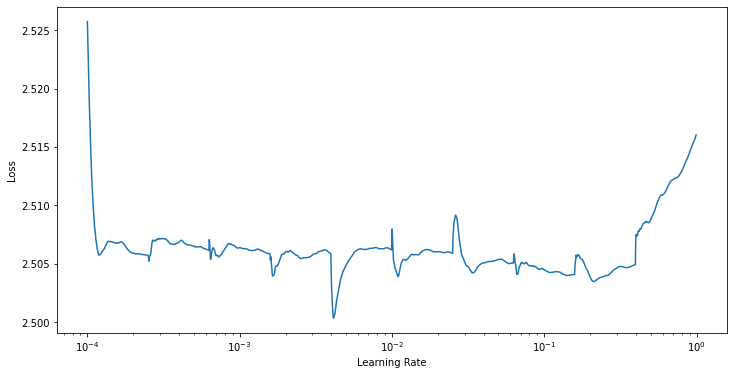

In [7]:
# Find the min max lr meaningful bounds to cycle through
# Ref: https://www.machinecurve.com/index.php/2020/02/25/training-your-neural-network-with-cyclical-learning-rates/
#!git clone https://github.com/WittmannF/LRFinder.git

from LRFinder.keras_callback import LRFinder
lr_finder = LRFinder(min_lr=1e-4, max_lr=1) # implemented as a callback

# Perform lr range test on 10 epochs
rob_kaf_cnn.fit(x_train, y_train, epochs = 10,batch_size=64, callbacks=[lr_finder])

In [9]:
# Set up cyclic learning (linear)
# ref: same as above
#!git clone https://github.com/bckenstler/CLR.git
from CLR.clr_callback import CyclicLR

# Set CLR options
step_size = int(4 * (50000/128))
base_lr = 1e-4
max_lr = 2e-1
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode=mode)

In [10]:
# Set Early Stopping
es = callbacks.EarlyStopping(
        monitor='val_accuracy',
        # "no longer improving" being defined as "no increase greater or equal than 1e-2"
        min_delta=5e-3,
        patience=10,
        mode='max', 
        verbose=1)

In [11]:
# plot diagnostic learning curves
def summarize_diagnostics(history, fine_tuning=False):
	
	if fine_tuning :
		color_train = 'green'
		color_validation = 'red'
	else :
		color_train = 'blue'
		color_validation = 'orange'

	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color=color_train, label='train')
	plt.plot(history.history['val_loss'], color=color_validation, label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color=color_train, label='train')
	plt.plot(history.history['val_accuracy'], color=color_validation, label='test')
	plt.show()
	plt.close()

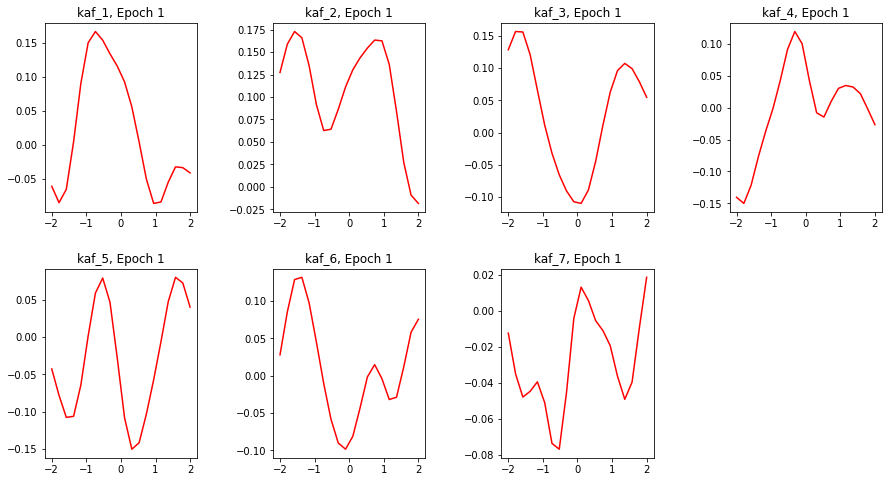

Epoch 1/100
782/782 [==============================] - 197s 252ms/step - loss: 2.4863 - accuracy: 0.1008 - val_loss: 2.4638 - val_accuracy: 0.0990


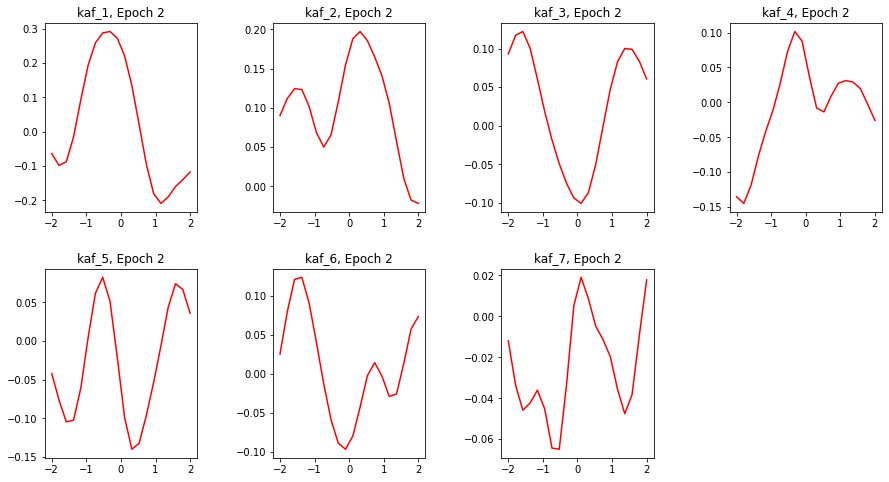

Epoch 2/100
782/782 [==============================] - 197s 251ms/step - loss: 2.4308 - accuracy: 0.1018 - val_loss: 2.3815 - val_accuracy: 0.0975


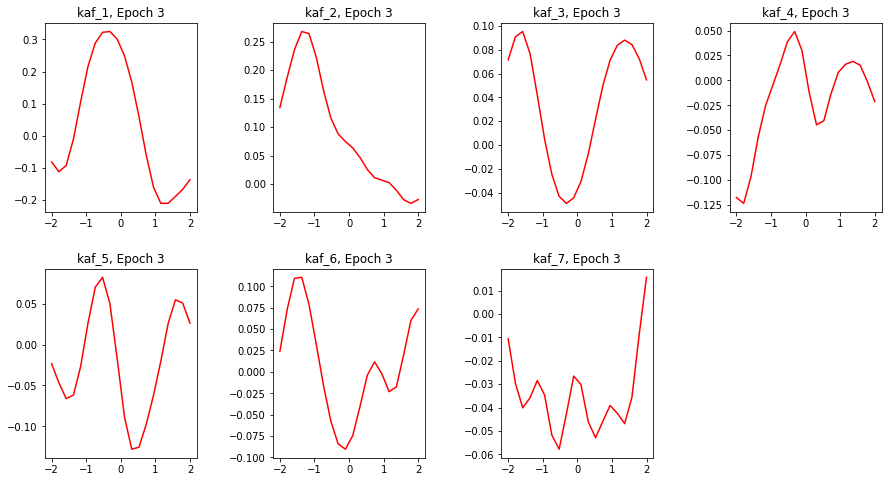

Epoch 3/100
782/782 [==============================] - 197s 252ms/step - loss: 2.1244 - accuracy: 0.1863 - val_loss: 1.9723 - val_accuracy: 0.2425


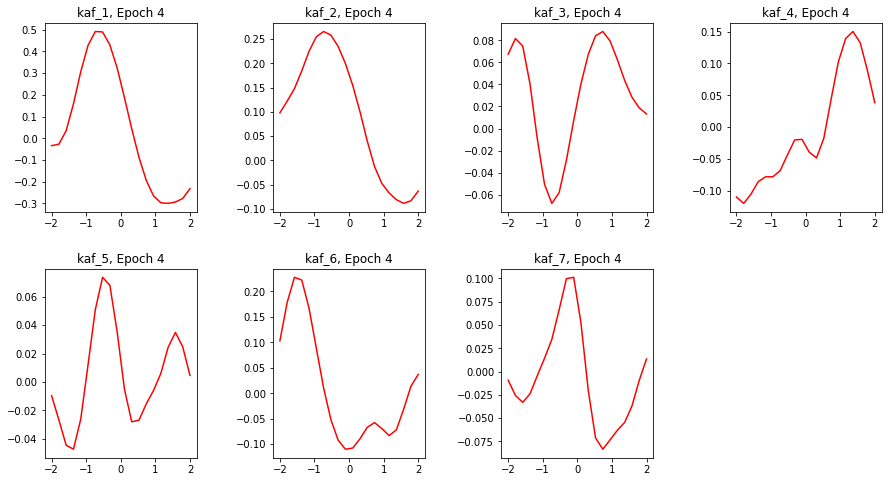

Epoch 4/100
782/782 [==============================] - 197s 251ms/step - loss: 1.9490 - accuracy: 0.2416 - val_loss: 1.8136 - val_accuracy: 0.3155


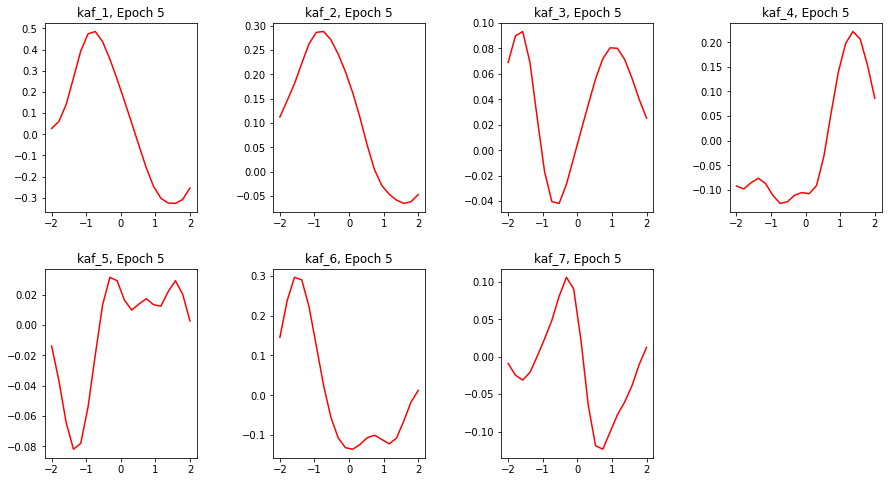

Epoch 5/100
782/782 [==============================] - 196s 251ms/step - loss: 1.8996 - accuracy: 0.2575 - val_loss: 1.7801 - val_accuracy: 0.3245


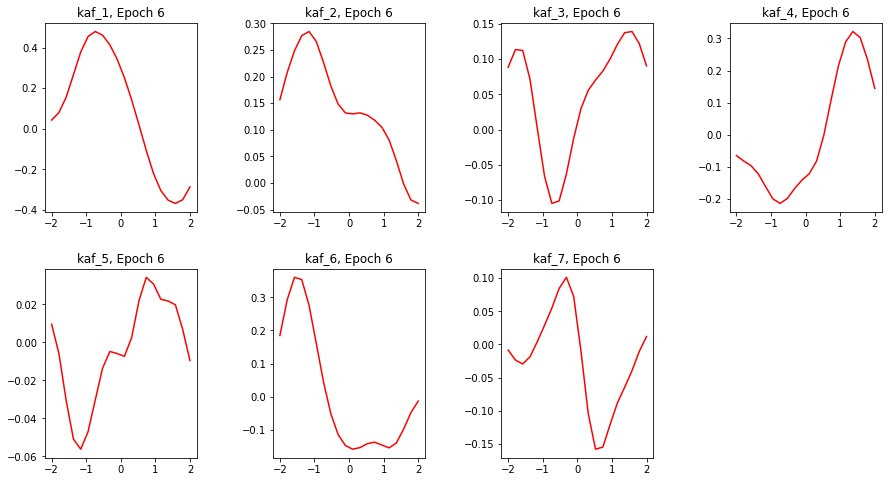

Epoch 6/100
782/782 [==============================] - 197s 252ms/step - loss: 1.8616 - accuracy: 0.2775 - val_loss: 1.7602 - val_accuracy: 0.3640


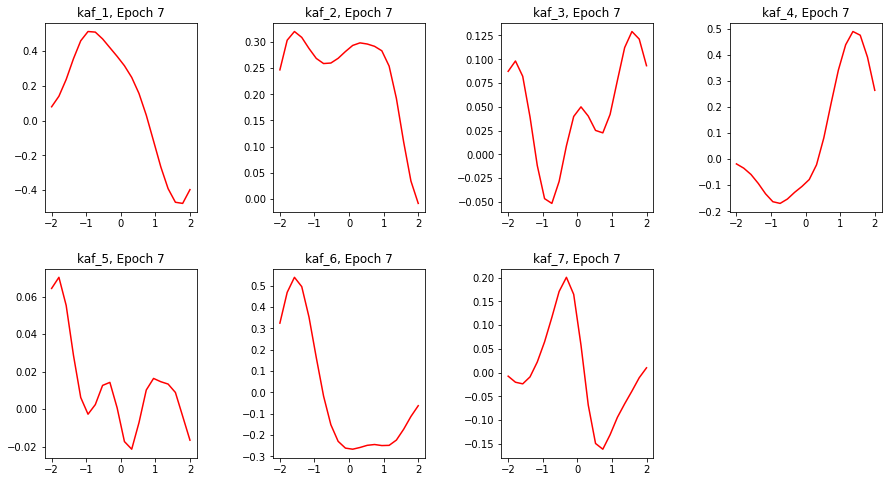

Epoch 7/100
782/782 [==============================] - 197s 251ms/step - loss: 1.7964 - accuracy: 0.2989 - val_loss: 1.6047 - val_accuracy: 0.4480


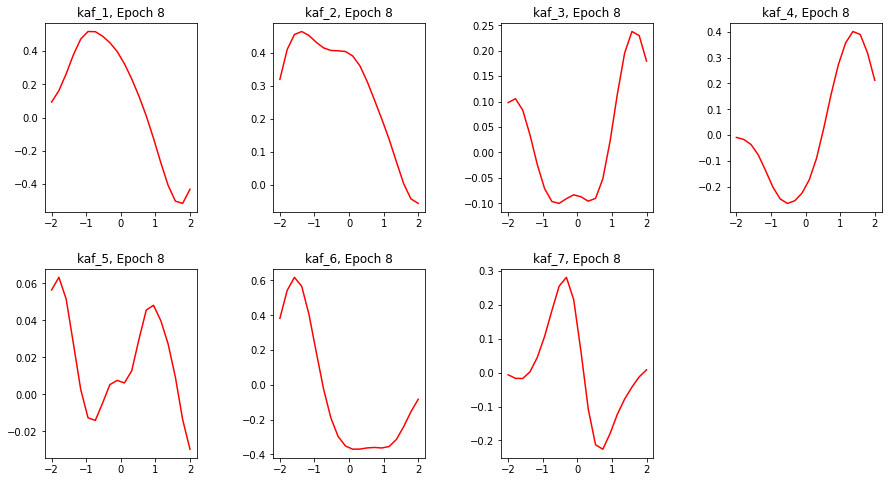

Epoch 8/100
782/782 [==============================] - 197s 252ms/step - loss: 1.7293 - accuracy: 0.3215 - val_loss: 1.5549 - val_accuracy: 0.4675


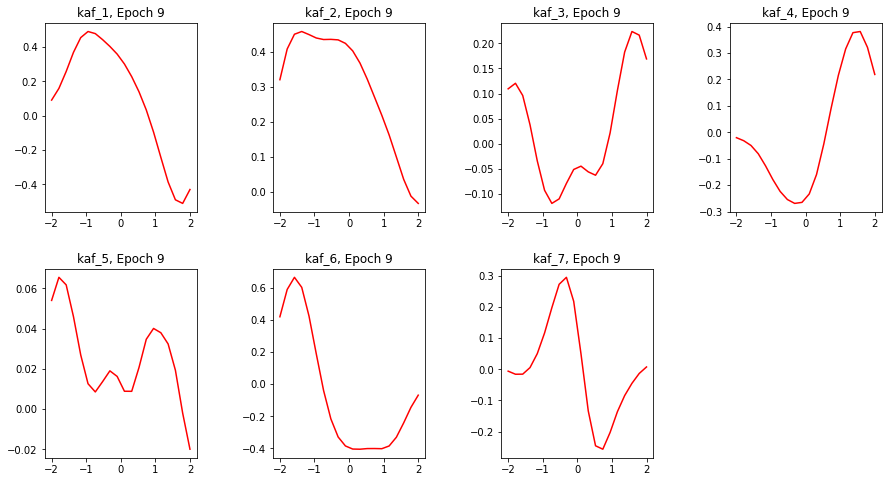

Epoch 9/100
782/782 [==============================] - 197s 252ms/step - loss: 1.7096 - accuracy: 0.3296 - val_loss: 1.5666 - val_accuracy: 0.4690


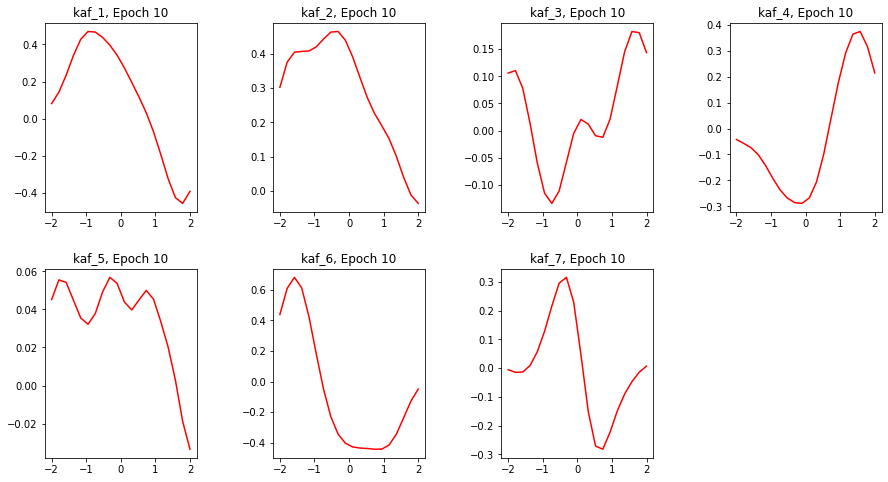

Epoch 10/100
782/782 [==============================] - 197s 252ms/step - loss: 1.7262 - accuracy: 0.3236 - val_loss: 1.6963 - val_accuracy: 0.3720


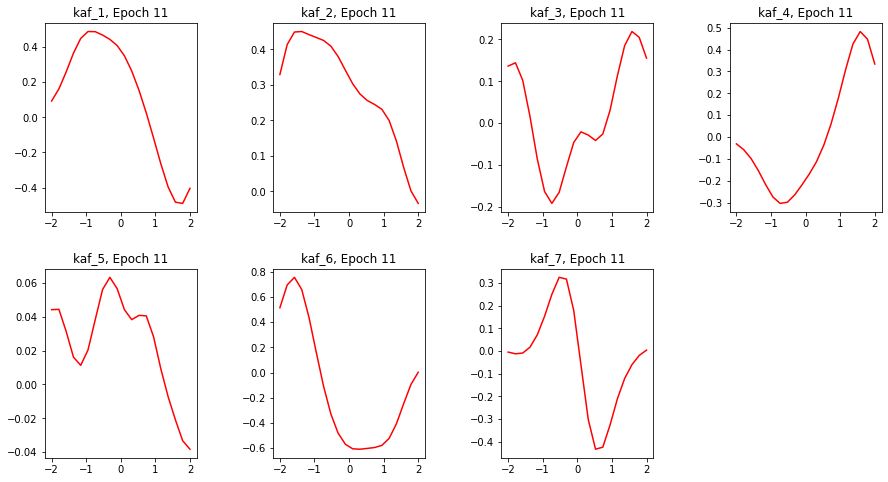

Epoch 11/100
782/782 [==============================] - 196s 251ms/step - loss: 1.6948 - accuracy: 0.3343 - val_loss: 1.6497 - val_accuracy: 0.4280


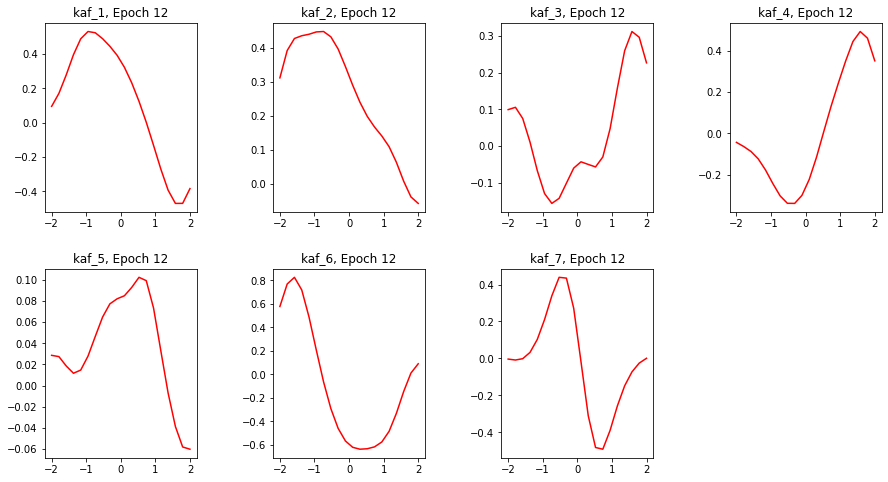

Epoch 12/100
782/782 [==============================] - 196s 251ms/step - loss: 1.6387 - accuracy: 0.3549 - val_loss: 1.4270 - val_accuracy: 0.5305


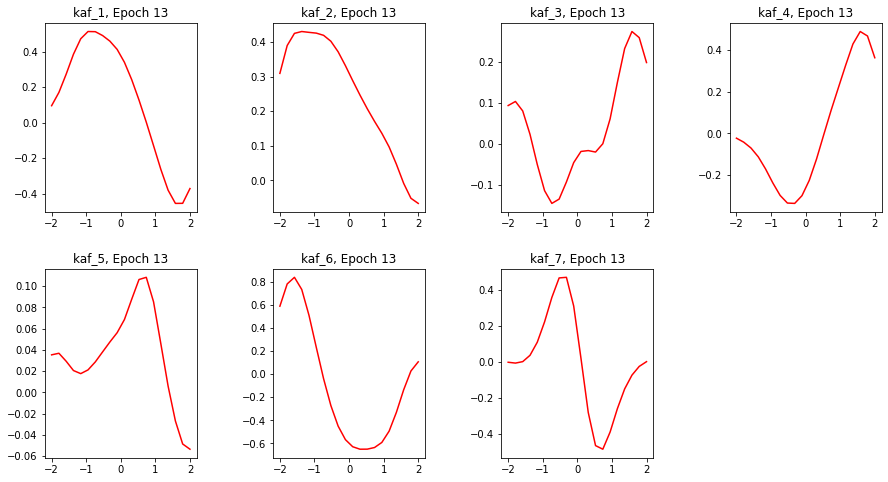

Epoch 13/100
782/782 [==============================] - 196s 251ms/step - loss: 1.6230 - accuracy: 0.3619 - val_loss: 1.5483 - val_accuracy: 0.4735


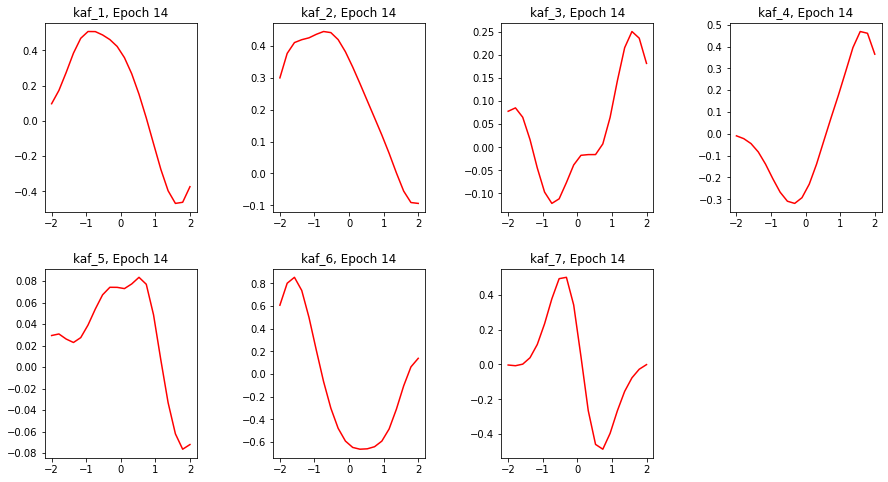

Epoch 14/100
782/782 [==============================] - 197s 251ms/step - loss: 1.6481 - accuracy: 0.3476 - val_loss: 1.5030 - val_accuracy: 0.4715


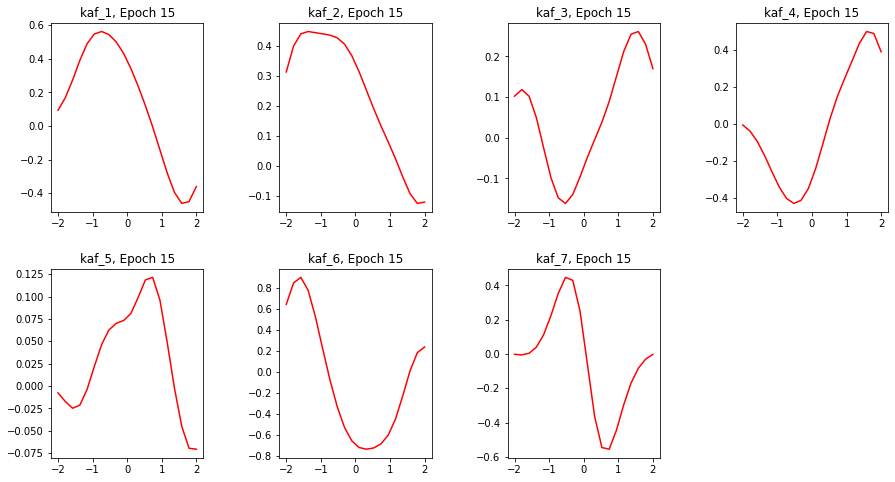

Epoch 15/100
782/782 [==============================] - 197s 252ms/step - loss: 1.6283 - accuracy: 0.3581 - val_loss: 1.4422 - val_accuracy: 0.5075


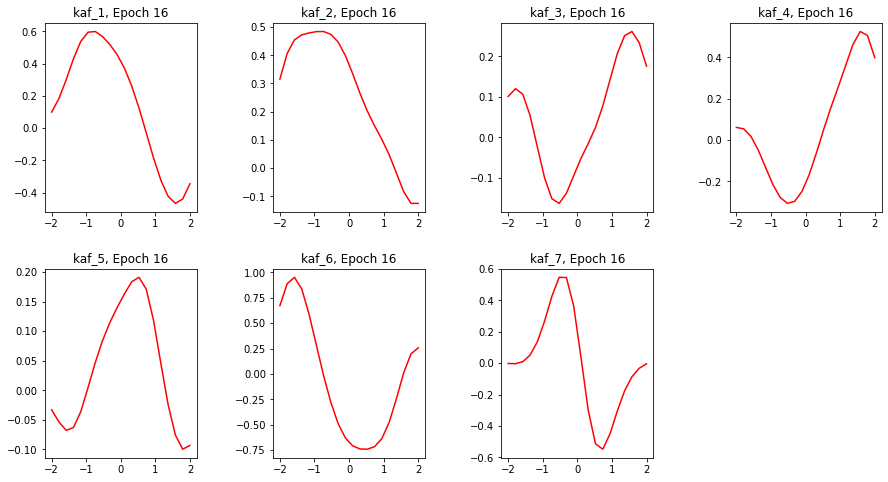

Epoch 16/100
782/782 [==============================] - 197s 251ms/step - loss: 1.5694 - accuracy: 0.3788 - val_loss: 1.3461 - val_accuracy: 0.5620


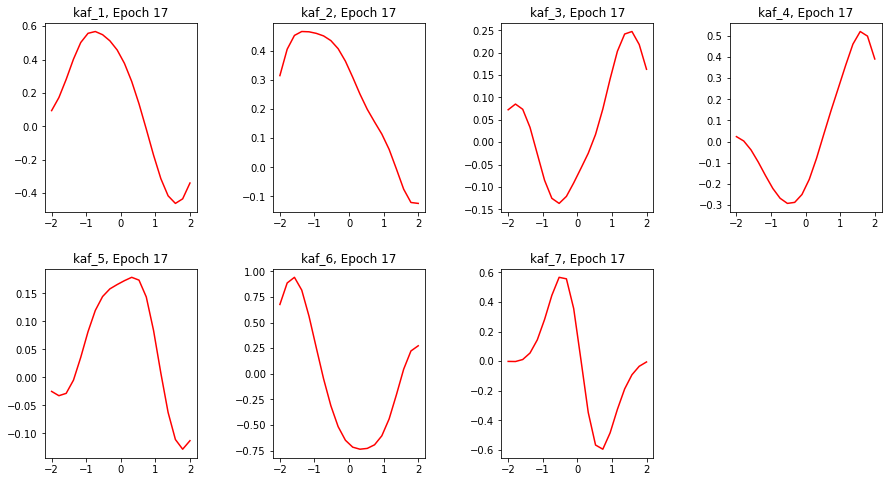

Epoch 17/100
782/782 [==============================] - 197s 251ms/step - loss: 1.5571 - accuracy: 0.3811 - val_loss: 1.3698 - val_accuracy: 0.5540


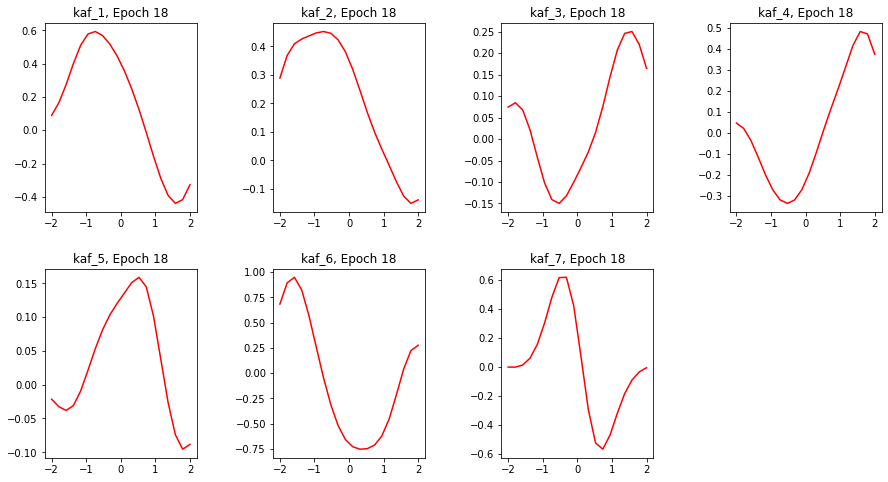

Epoch 18/100
782/782 [==============================] - 197s 251ms/step - loss: 1.5930 - accuracy: 0.3719 - val_loss: 1.5114 - val_accuracy: 0.4900


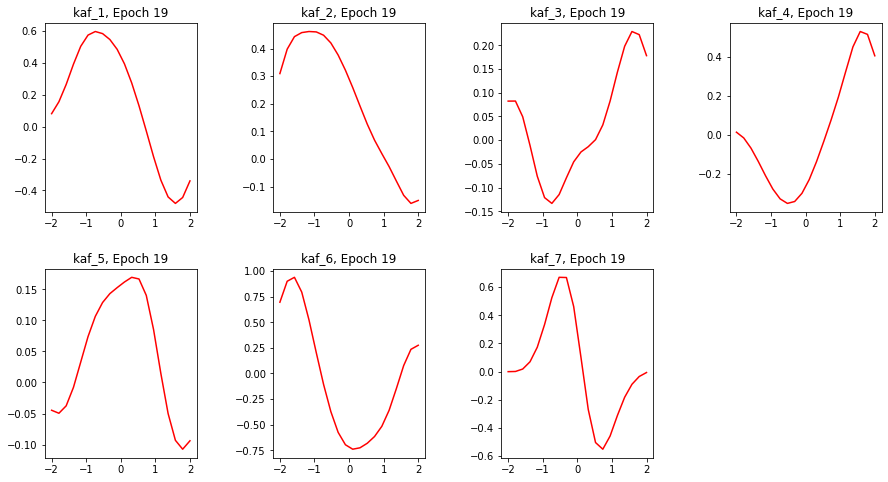

Epoch 19/100
782/782 [==============================] - 197s 251ms/step - loss: 1.5772 - accuracy: 0.3741 - val_loss: 1.3835 - val_accuracy: 0.5385


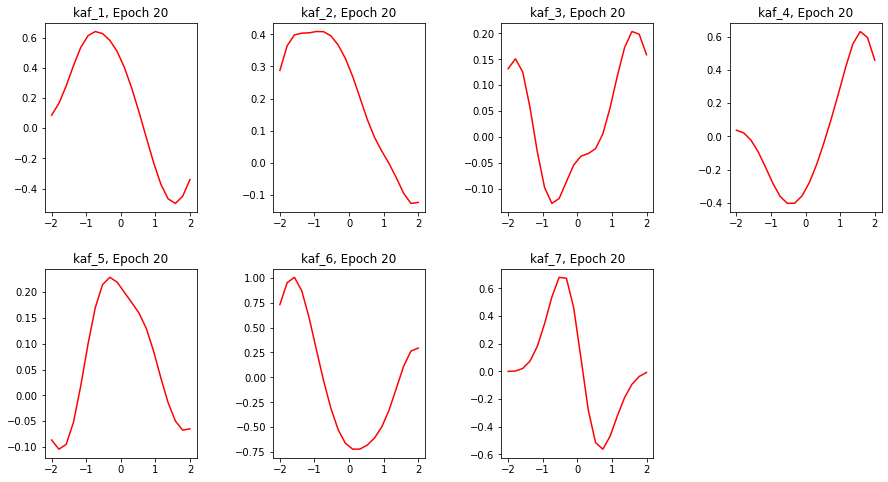

Epoch 20/100
782/782 [==============================] - 197s 251ms/step - loss: 1.5162 - accuracy: 0.3965 - val_loss: 1.2789 - val_accuracy: 0.5860


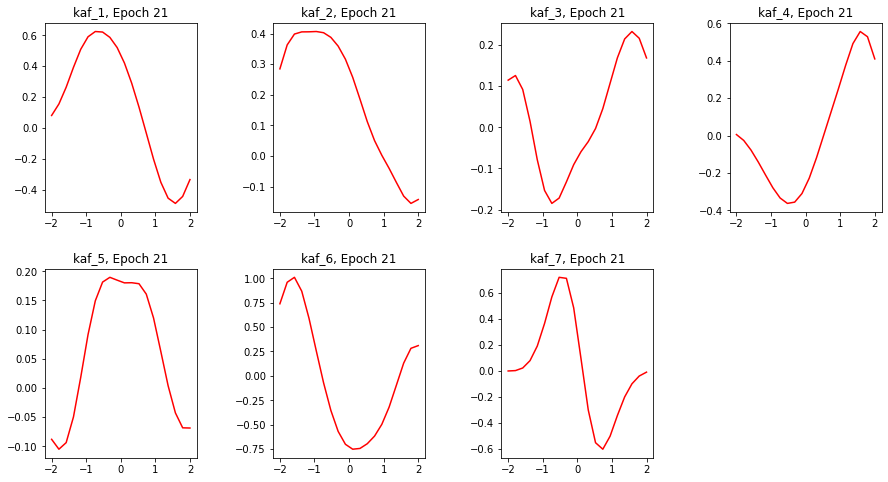

Epoch 21/100
782/782 [==============================] - 196s 251ms/step - loss: 1.5045 - accuracy: 0.4007 - val_loss: 1.3300 - val_accuracy: 0.5515


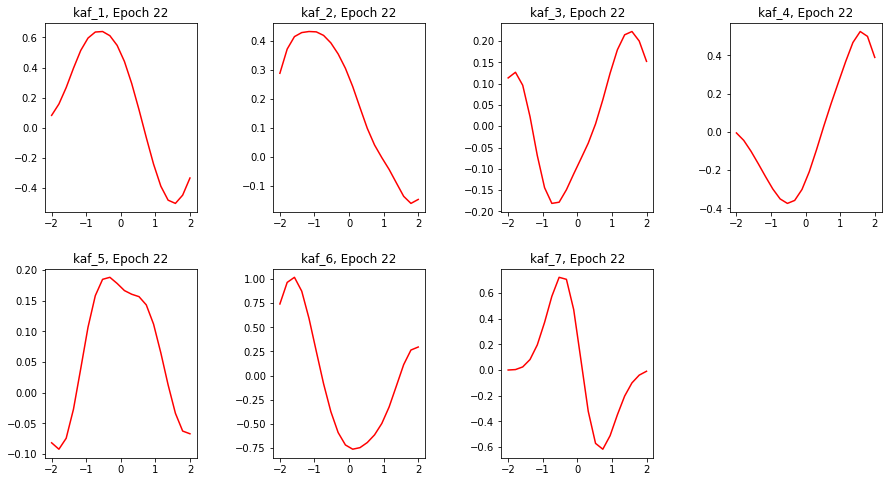

Epoch 22/100
782/782 [==============================] - 197s 251ms/step - loss: 1.5475 - accuracy: 0.3843 - val_loss: 1.5377 - val_accuracy: 0.4705


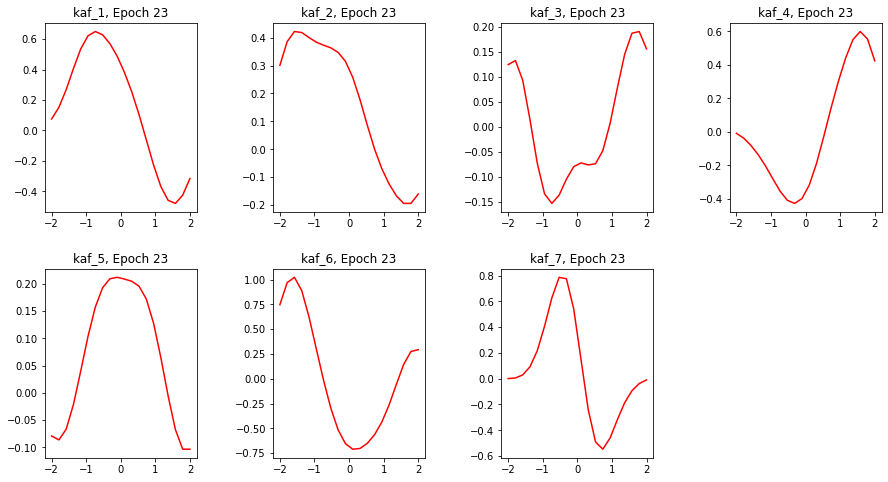

Epoch 23/100
782/782 [==============================] - 197s 252ms/step - loss: 1.5322 - accuracy: 0.3891 - val_loss: 1.3473 - val_accuracy: 0.5425


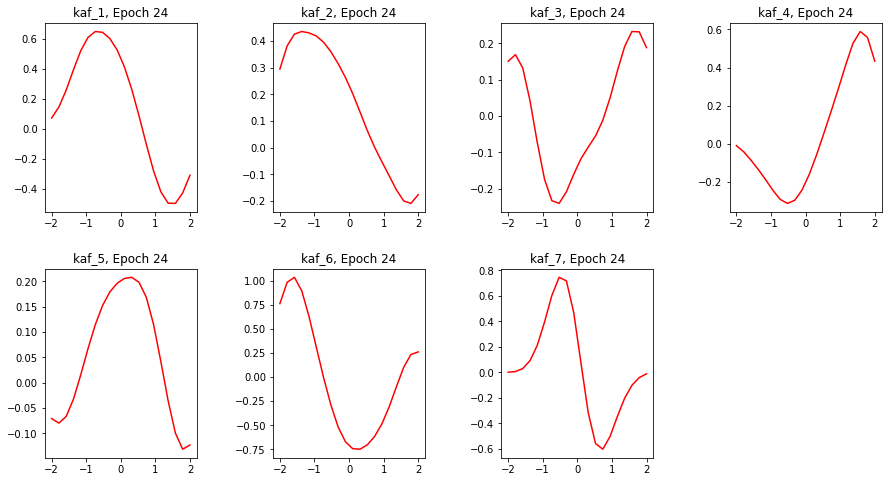

Epoch 24/100
782/782 [==============================] - 196s 251ms/step - loss: 1.4750 - accuracy: 0.4090 - val_loss: 1.2377 - val_accuracy: 0.6005


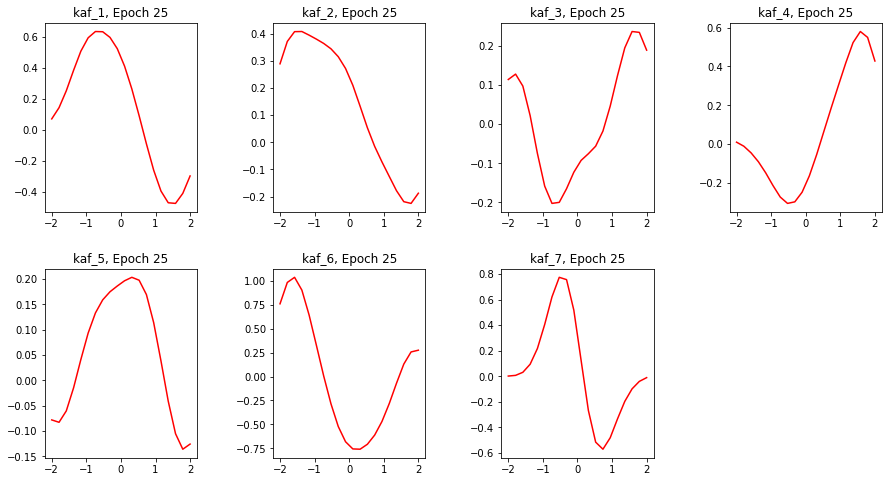

Epoch 25/100
782/782 [==============================] - 197s 251ms/step - loss: 1.4644 - accuracy: 0.4118 - val_loss: 1.3661 - val_accuracy: 0.5110


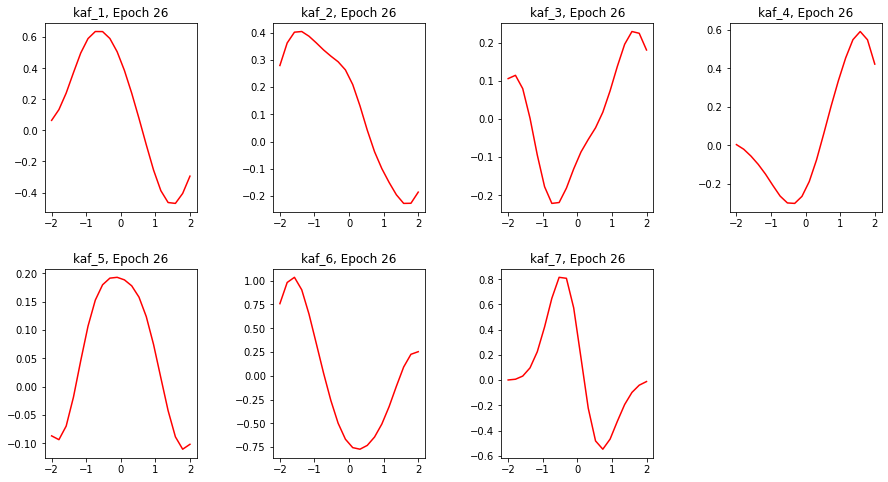

Epoch 26/100
782/782 [==============================] - 197s 252ms/step - loss: 1.5095 - accuracy: 0.3977 - val_loss: 1.3943 - val_accuracy: 0.5110


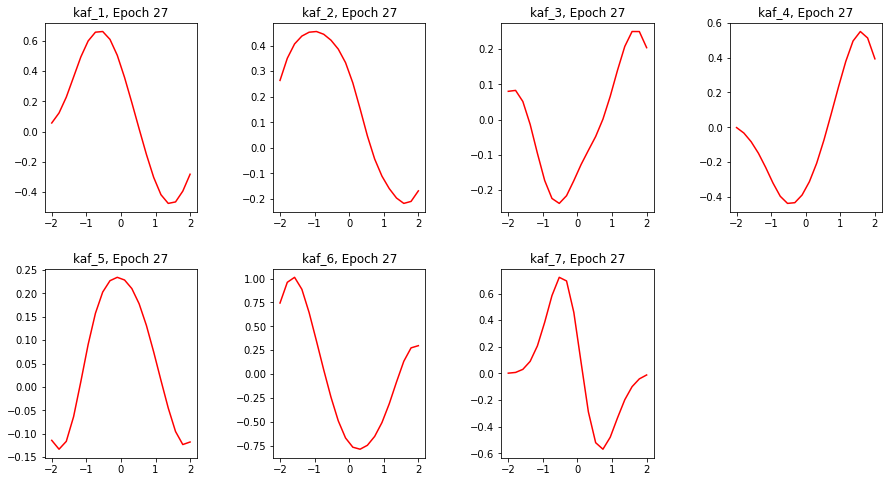

Epoch 27/100
782/782 [==============================] - 197s 251ms/step - loss: 1.4989 - accuracy: 0.4006 - val_loss: 1.3420 - val_accuracy: 0.5705


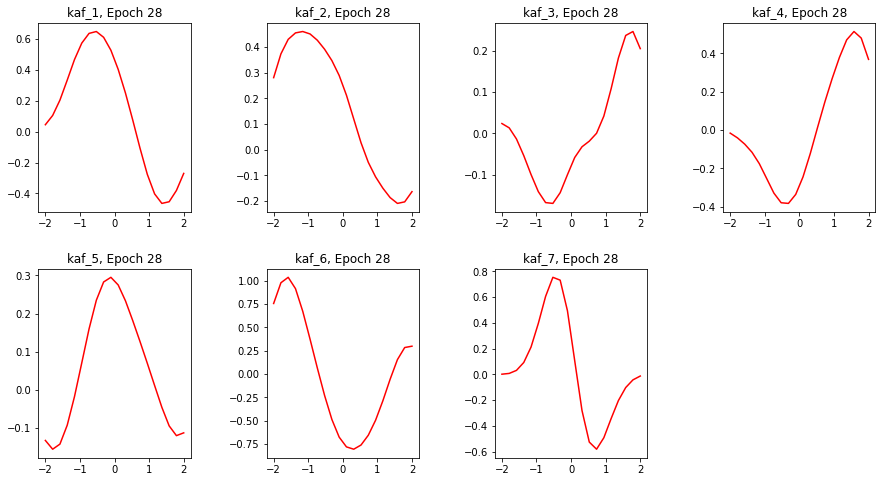

Epoch 28/100
782/782 [==============================] - 197s 251ms/step - loss: 1.4383 - accuracy: 0.4240 - val_loss: 1.1963 - val_accuracy: 0.6235


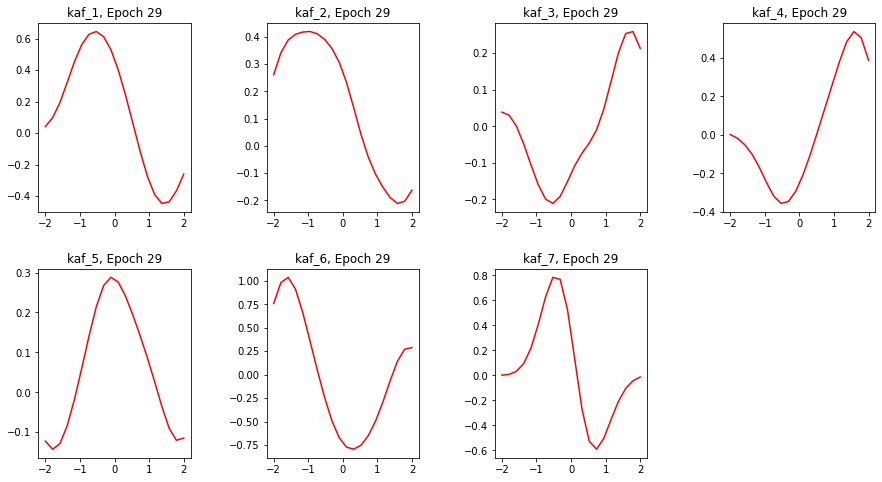

Epoch 29/100
782/782 [==============================] - 197s 252ms/step - loss: 1.4272 - accuracy: 0.4261 - val_loss: 1.2245 - val_accuracy: 0.5885


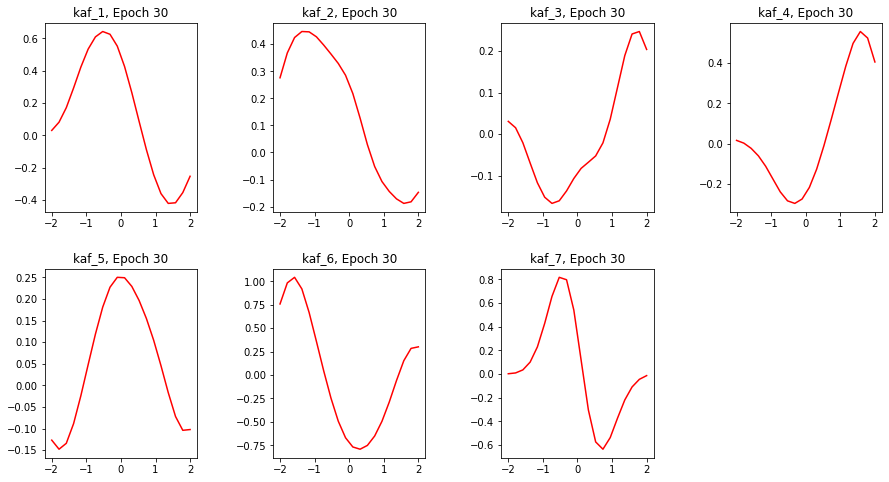

Epoch 30/100
782/782 [==============================] - 197s 251ms/step - loss: 1.4715 - accuracy: 0.4087 - val_loss: 1.5499 - val_accuracy: 0.4770


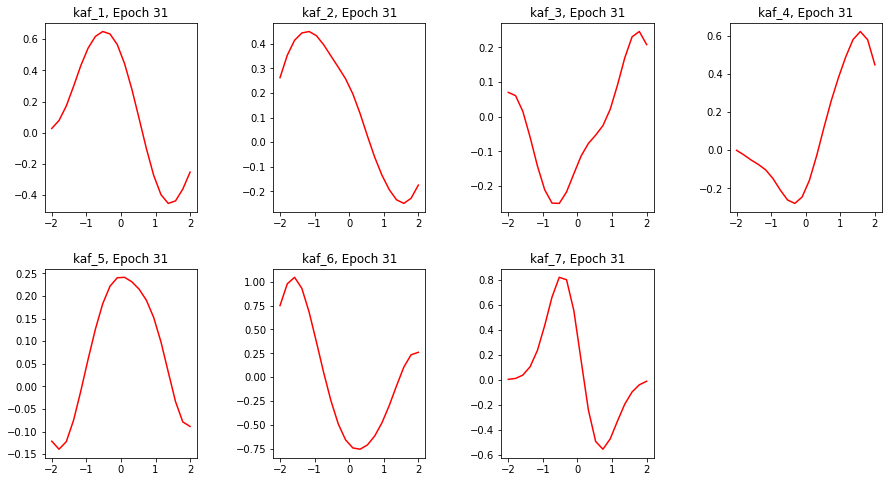

Epoch 31/100
782/782 [==============================] - 197s 252ms/step - loss: 1.4676 - accuracy: 0.4138 - val_loss: 1.4151 - val_accuracy: 0.5490


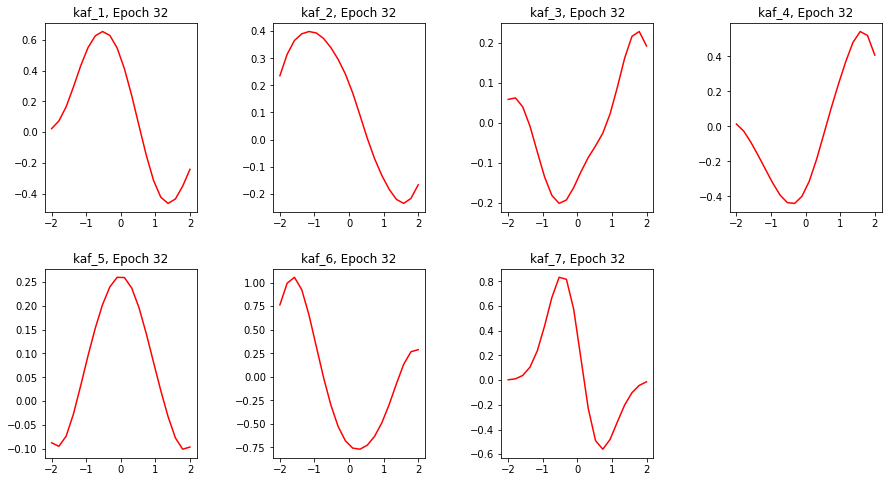

Epoch 32/100
782/782 [==============================] - 197s 252ms/step - loss: 1.4019 - accuracy: 0.4361 - val_loss: 1.1589 - val_accuracy: 0.6320


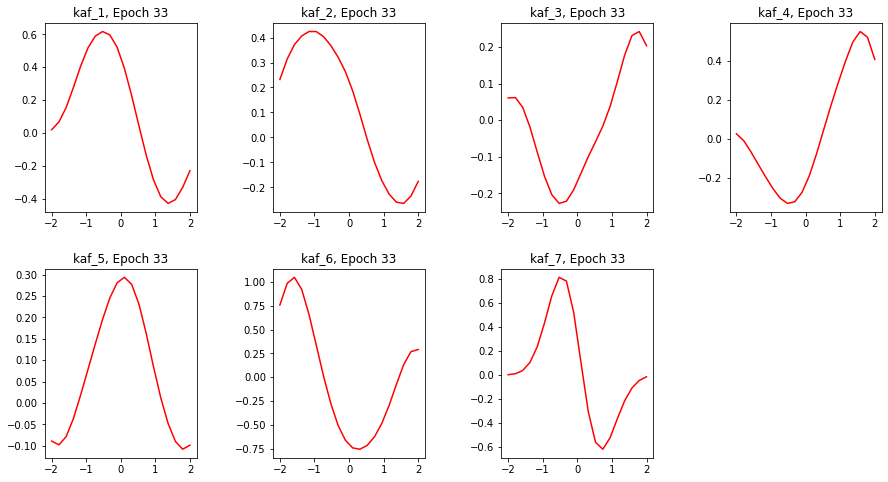

Epoch 33/100
782/782 [==============================] - 197s 252ms/step - loss: 1.3932 - accuracy: 0.4377 - val_loss: 1.3277 - val_accuracy: 0.5315


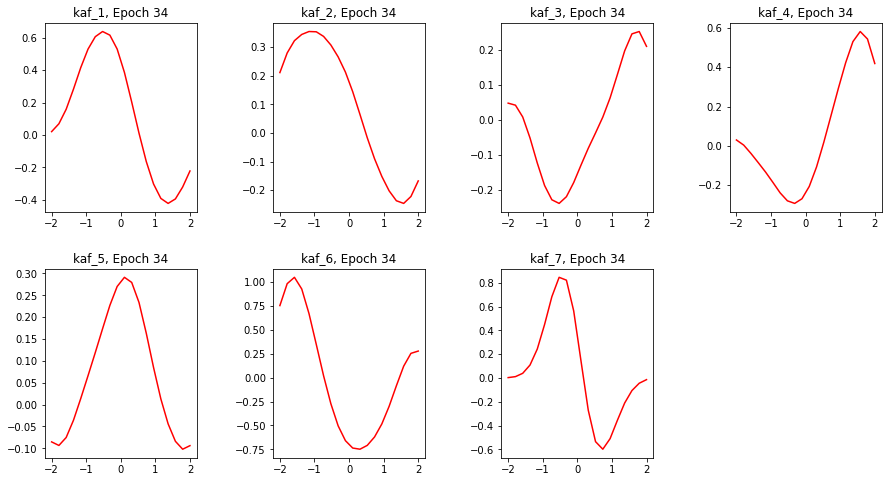

Epoch 34/100
782/782 [==============================] - 197s 252ms/step - loss: 1.4459 - accuracy: 0.4184 - val_loss: 1.3087 - val_accuracy: 0.5570


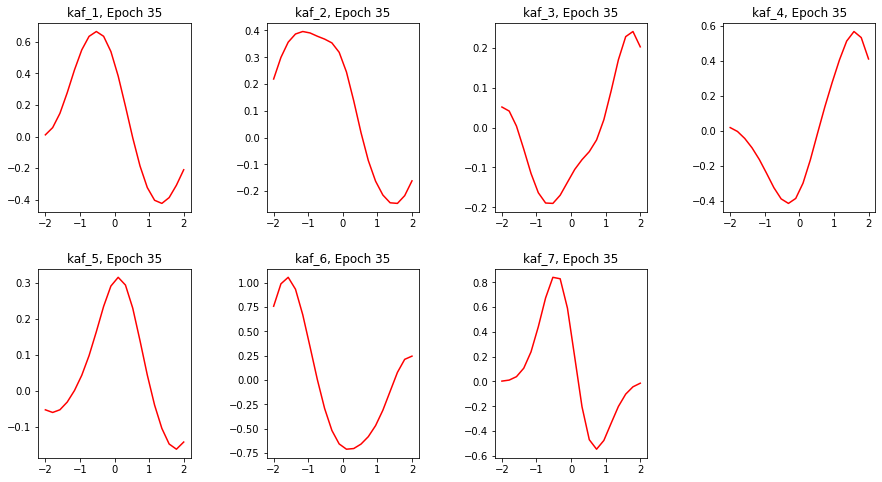

Epoch 35/100
782/782 [==============================] - 196s 251ms/step - loss: 1.4394 - accuracy: 0.4226 - val_loss: 1.3575 - val_accuracy: 0.5575


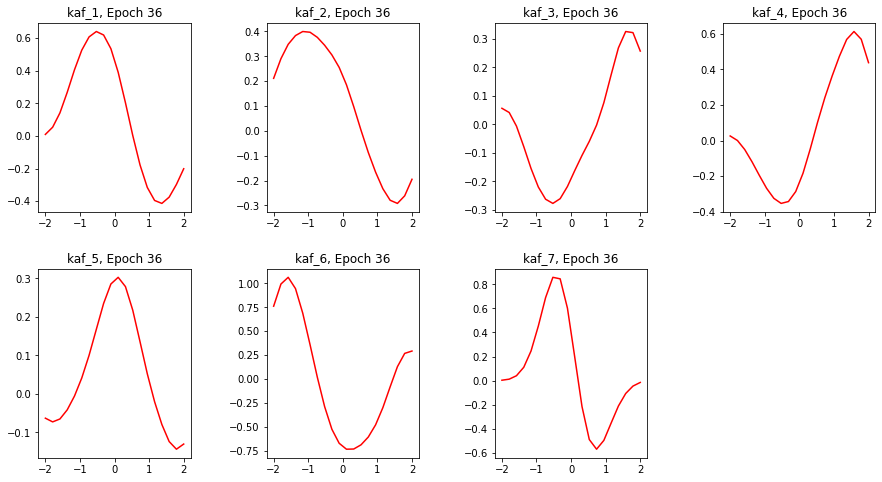

Epoch 36/100
782/782 [==============================] - 196s 251ms/step - loss: 1.3775 - accuracy: 0.4414 - val_loss: 1.1343 - val_accuracy: 0.6435


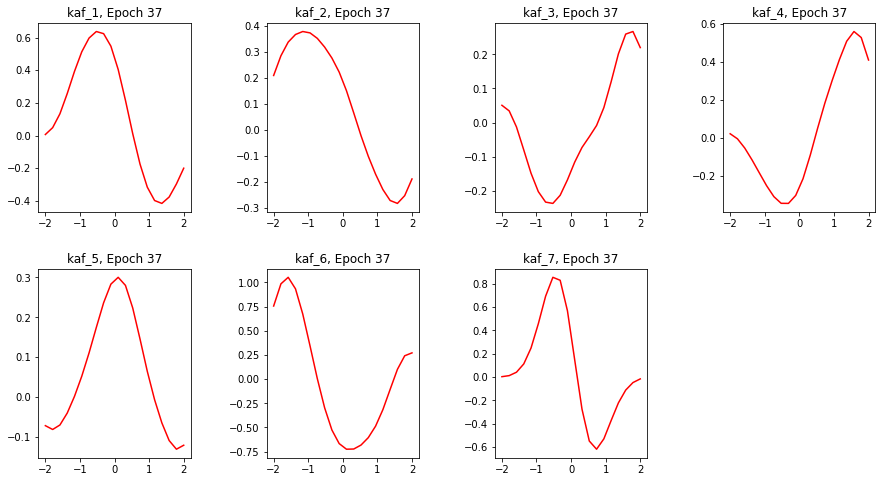

Epoch 37/100
782/782 [==============================] - 196s 251ms/step - loss: 1.3683 - accuracy: 0.4477 - val_loss: 1.2199 - val_accuracy: 0.6140


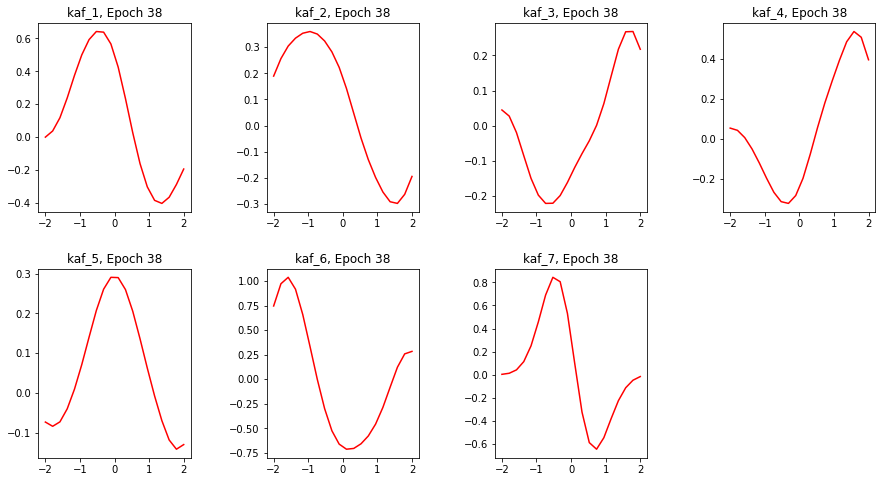

Epoch 38/100
782/782 [==============================] - 197s 251ms/step - loss: 1.4198 - accuracy: 0.4287 - val_loss: 1.3853 - val_accuracy: 0.5300


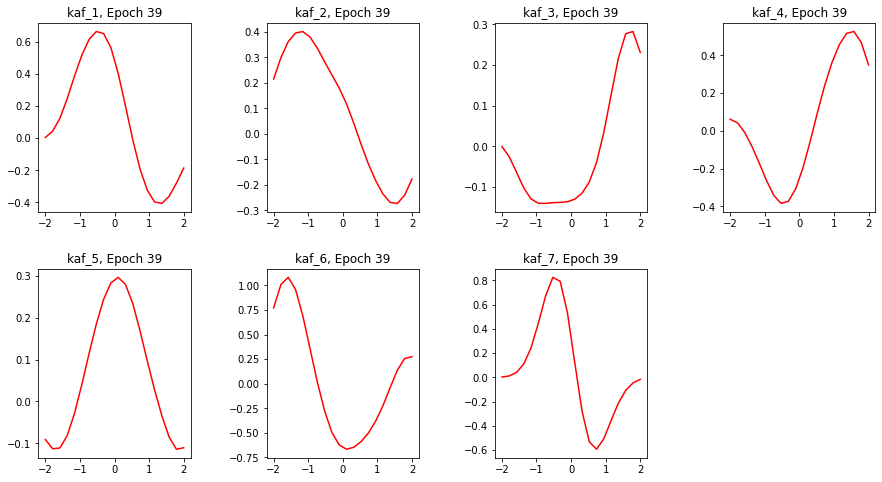

Epoch 39/100
782/782 [==============================] - 197s 251ms/step - loss: 1.4110 - accuracy: 0.4303 - val_loss: 1.1951 - val_accuracy: 0.6350


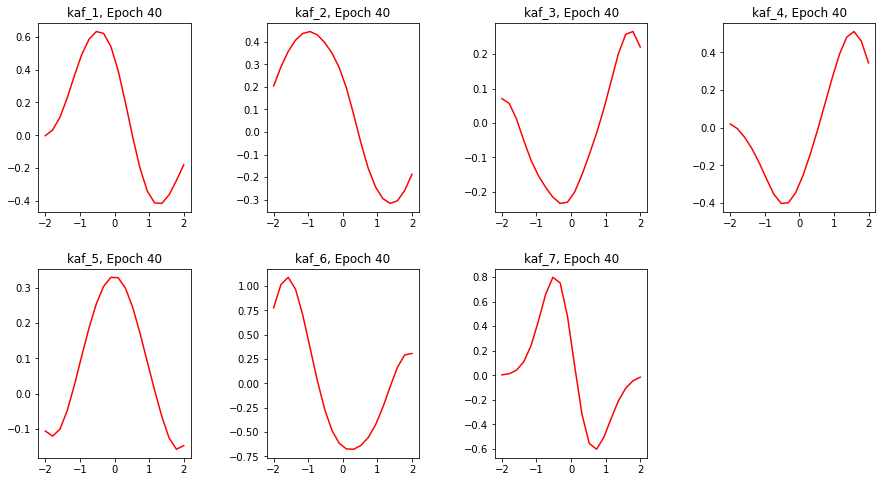

Epoch 40/100
782/782 [==============================] - 197s 252ms/step - loss: 1.3511 - accuracy: 0.4519 - val_loss: 1.1060 - val_accuracy: 0.6530


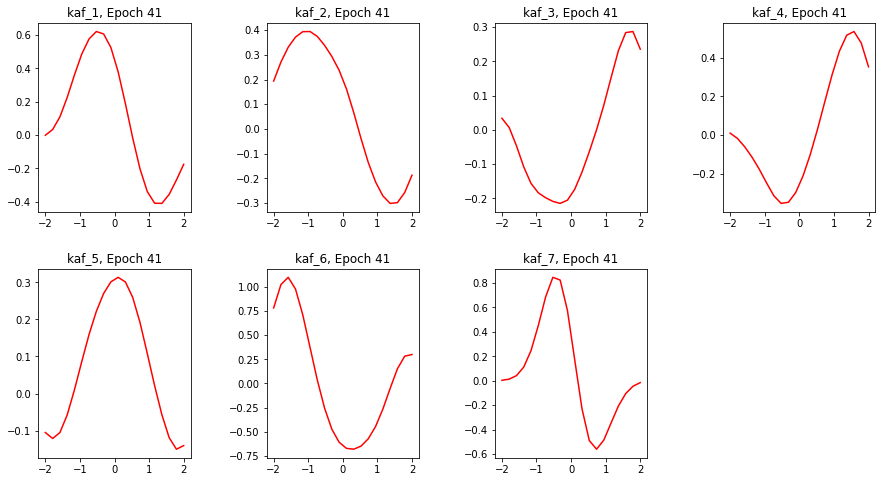

Epoch 41/100
782/782 [==============================] - 197s 251ms/step - loss: 1.3407 - accuracy: 0.4609 - val_loss: 1.2355 - val_accuracy: 0.5955


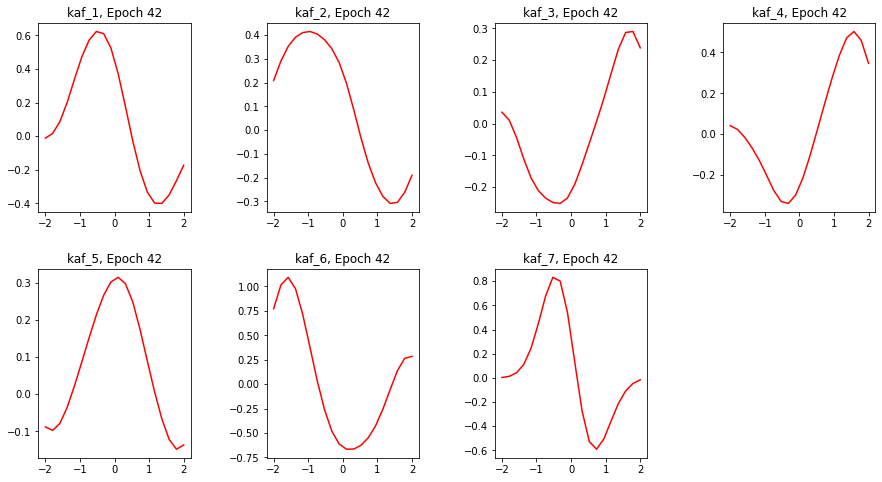

Epoch 42/100
782/782 [==============================] - 197s 252ms/step - loss: 1.3965 - accuracy: 0.4356 - val_loss: 1.3704 - val_accuracy: 0.5350


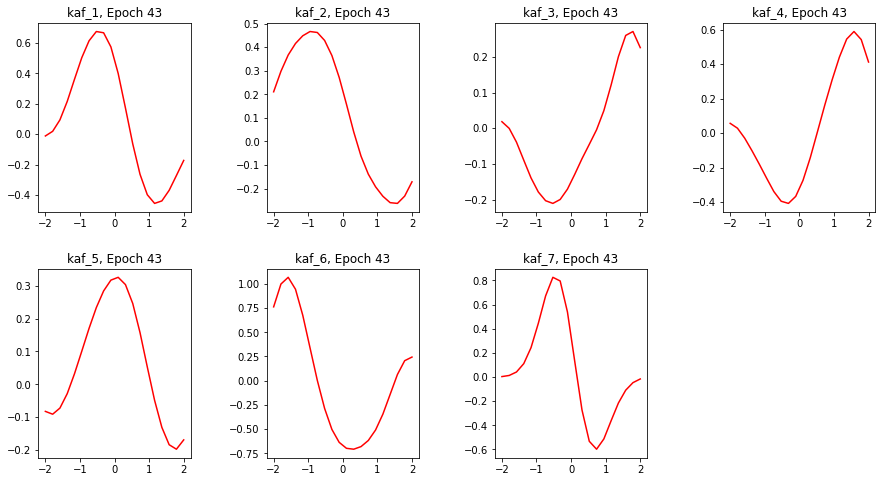

Epoch 43/100
782/782 [==============================] - 196s 251ms/step - loss: 1.3871 - accuracy: 0.4394 - val_loss: 1.1837 - val_accuracy: 0.6230


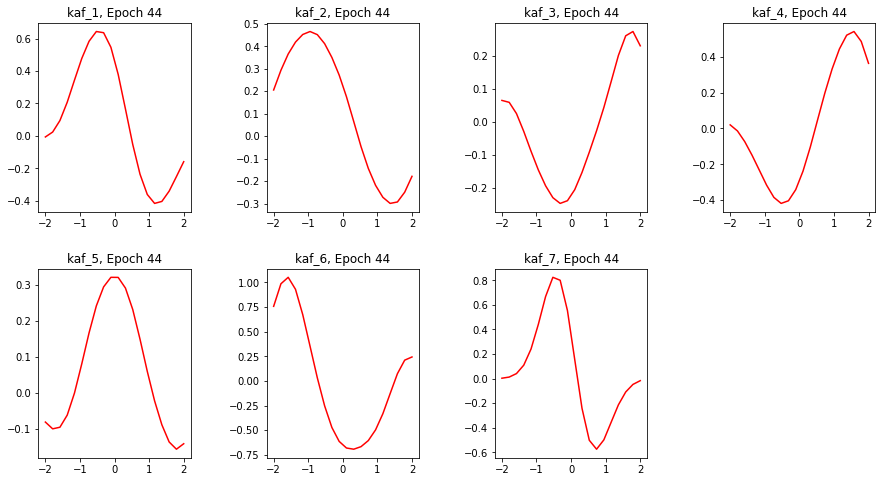

Epoch 44/100
782/782 [==============================] - 196s 250ms/step - loss: 1.3234 - accuracy: 0.4650 - val_loss: 1.0869 - val_accuracy: 0.6605


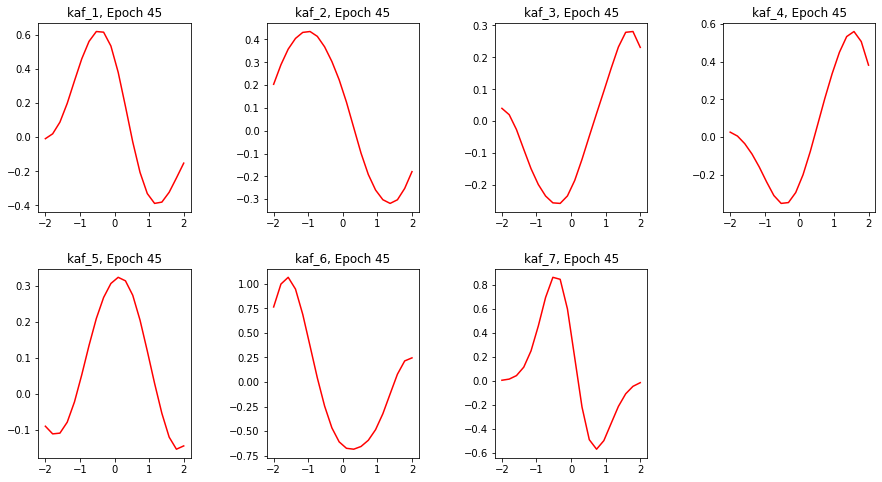

Epoch 45/100
782/782 [==============================] - 197s 253ms/step - loss: 1.3169 - accuracy: 0.4649 - val_loss: 1.2339 - val_accuracy: 0.6075


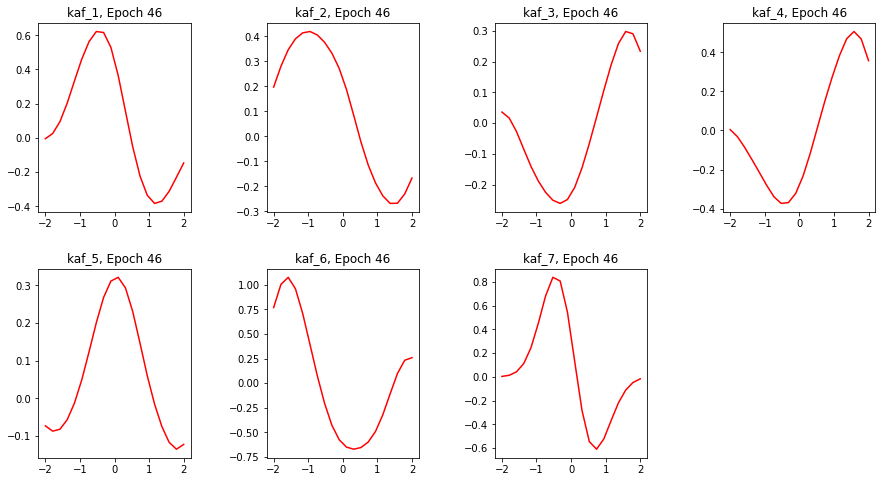

Epoch 46/100
782/782 [==============================] - 198s 253ms/step - loss: 1.3732 - accuracy: 0.4472 - val_loss: 1.3581 - val_accuracy: 0.5710


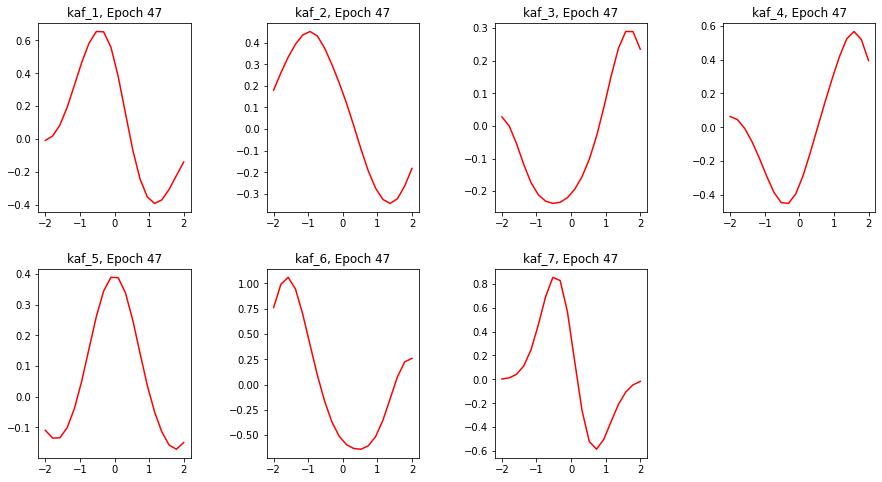

Epoch 47/100
782/782 [==============================] - 197s 252ms/step - loss: 1.3678 - accuracy: 0.4481 - val_loss: 1.1937 - val_accuracy: 0.6310


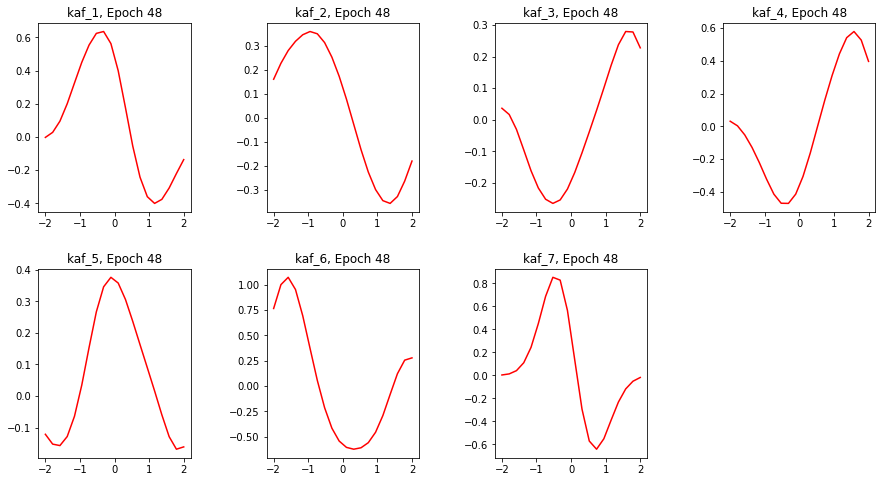

Epoch 48/100
782/782 [==============================] - 197s 252ms/step - loss: 1.3032 - accuracy: 0.4711 - val_loss: 1.0682 - val_accuracy: 0.6680


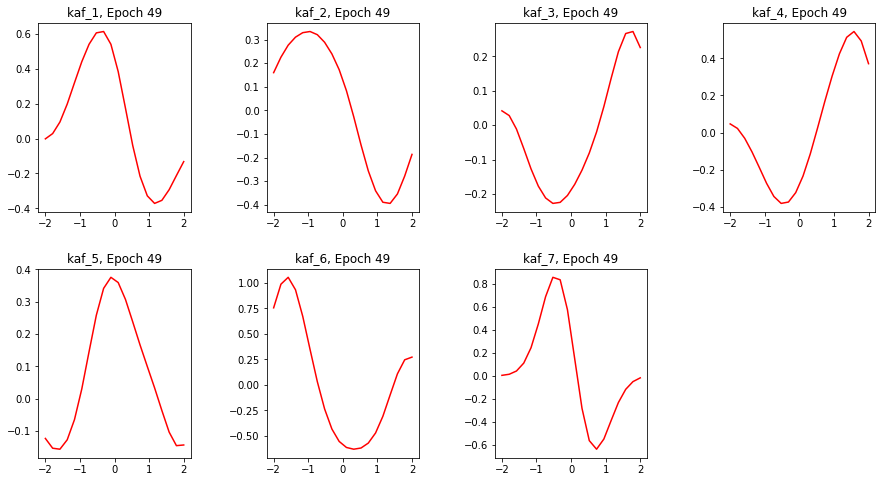

Epoch 49/100
782/782 [==============================] - 197s 252ms/step - loss: 1.2949 - accuracy: 0.4748 - val_loss: 1.2724 - val_accuracy: 0.6230


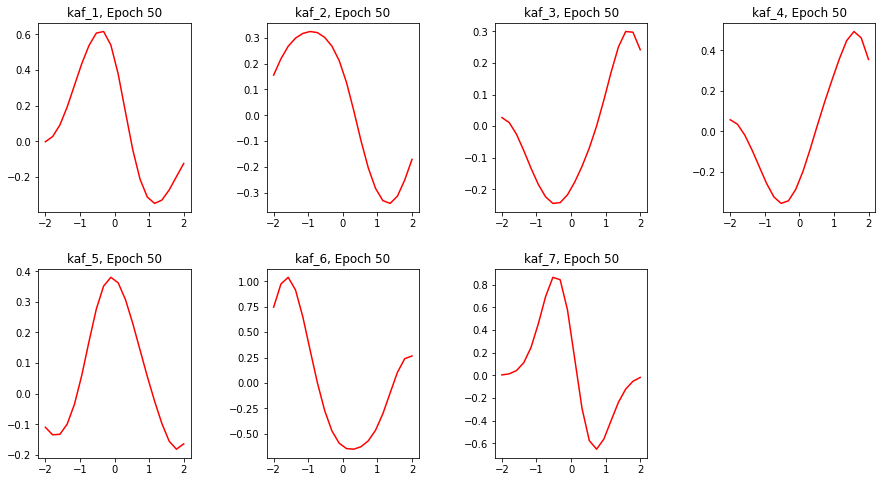

Epoch 50/100
782/782 [==============================] - 198s 253ms/step - loss: 1.3553 - accuracy: 0.4531 - val_loss: 1.2276 - val_accuracy: 0.5845


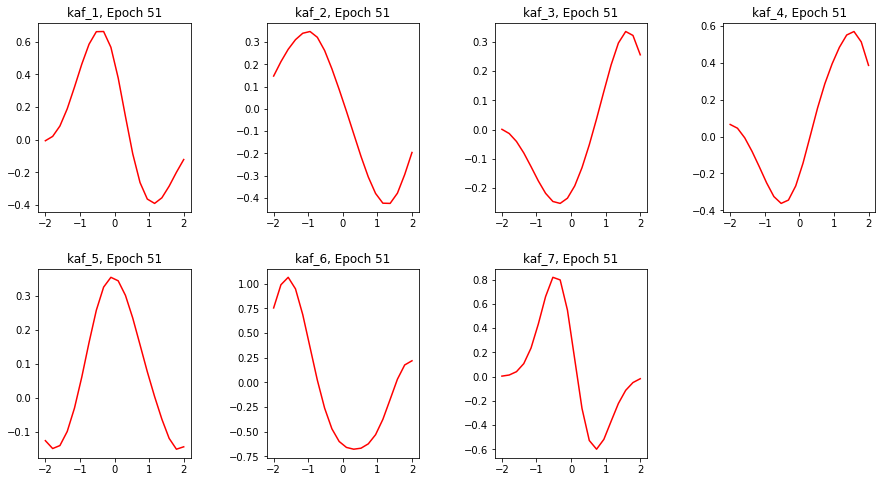

Epoch 51/100
782/782 [==============================] - 198s 253ms/step - loss: 1.3471 - accuracy: 0.4546 - val_loss: 1.1604 - val_accuracy: 0.6350


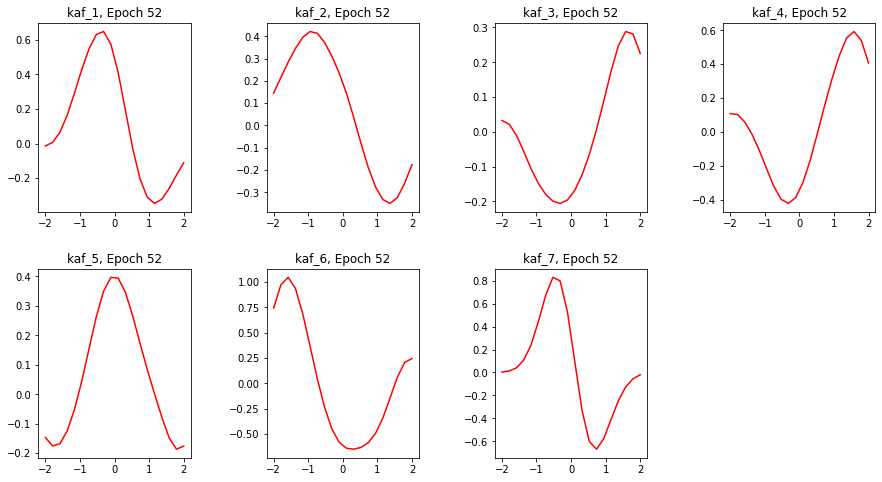

Epoch 52/100
782/782 [==============================] - 198s 253ms/step - loss: 1.2814 - accuracy: 0.4789 - val_loss: 1.0470 - val_accuracy: 0.6710


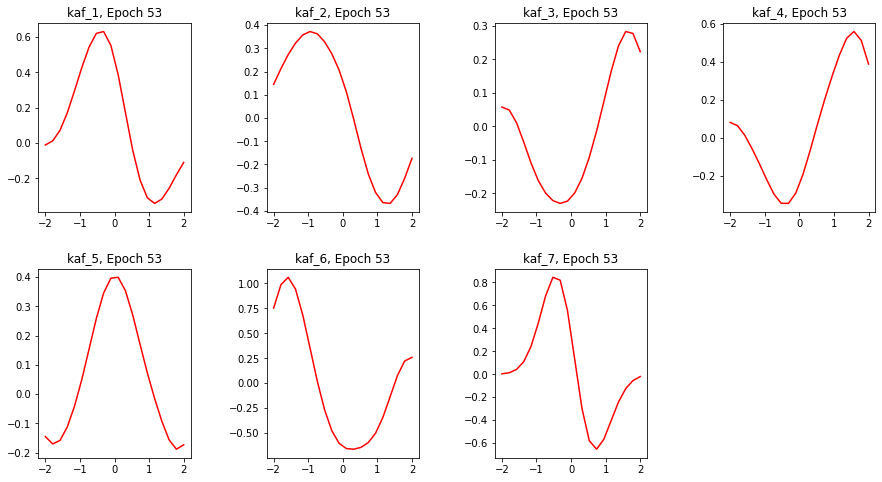

Epoch 53/100
782/782 [==============================] - 197s 252ms/step - loss: 1.2733 - accuracy: 0.4833 - val_loss: 1.0744 - val_accuracy: 0.6435


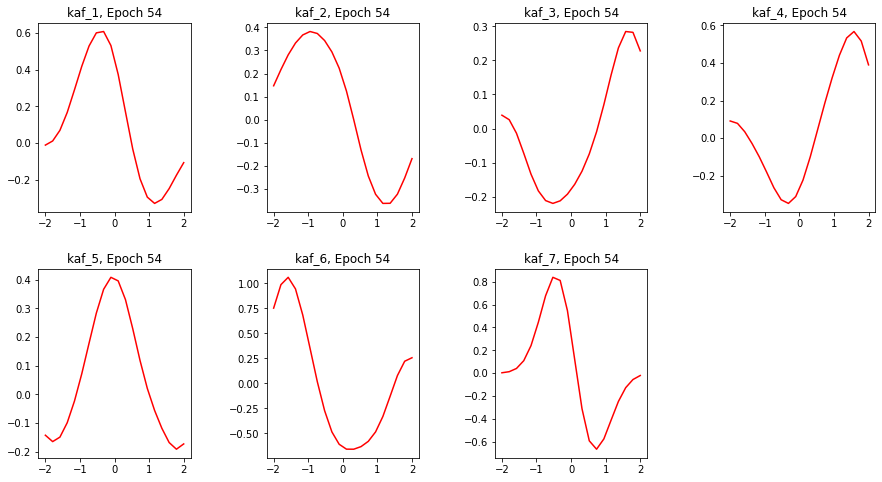

Epoch 54/100
782/782 [==============================] - 196s 251ms/step - loss: 1.3330 - accuracy: 0.4621 - val_loss: 1.2470 - val_accuracy: 0.5960


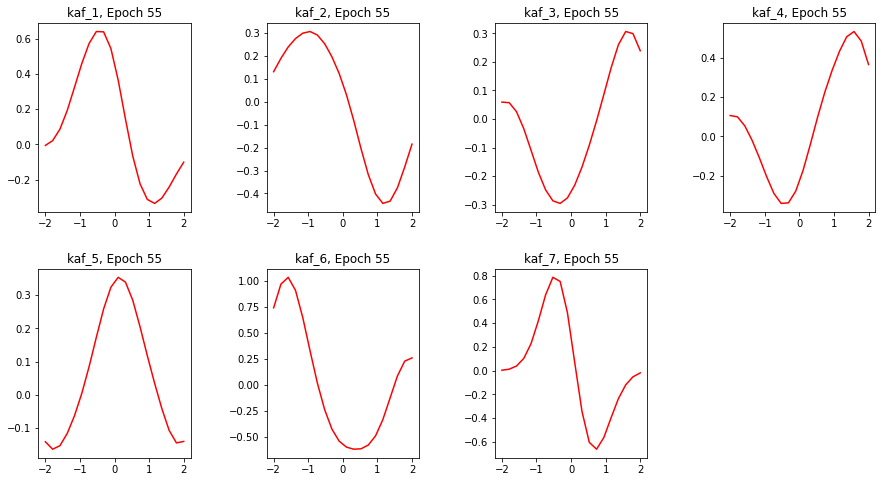

Epoch 55/100
782/782 [==============================] - 197s 251ms/step - loss: 1.3290 - accuracy: 0.4617 - val_loss: 1.1215 - val_accuracy: 0.6565


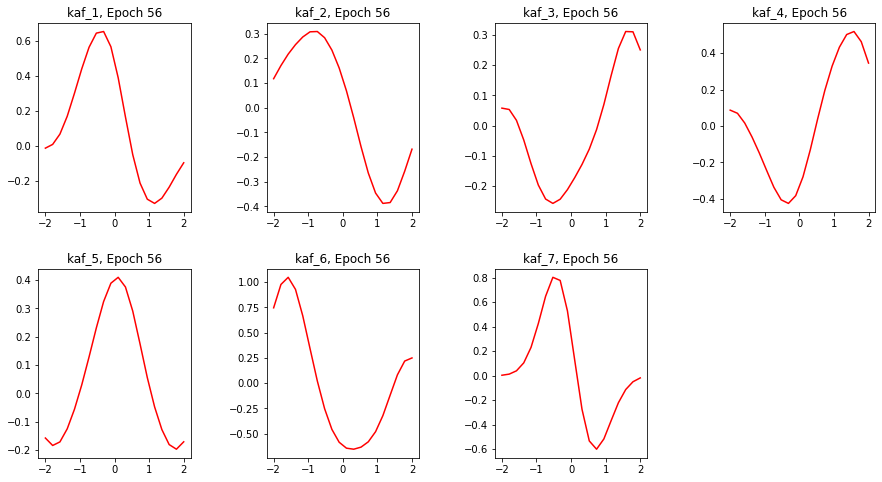

Epoch 56/100
782/782 [==============================] - 197s 252ms/step - loss: 1.2686 - accuracy: 0.4842 - val_loss: 1.0390 - val_accuracy: 0.6805


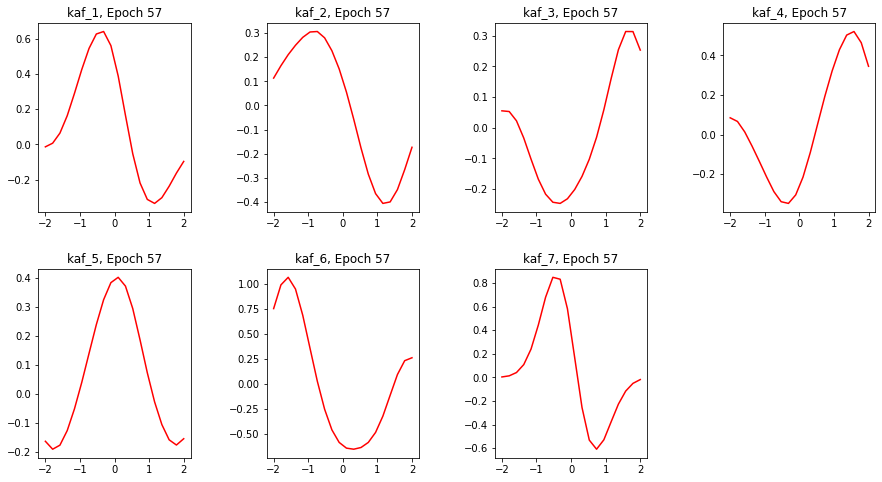

Epoch 57/100
782/782 [==============================] - 197s 252ms/step - loss: 1.2585 - accuracy: 0.4886 - val_loss: 1.1906 - val_accuracy: 0.6145


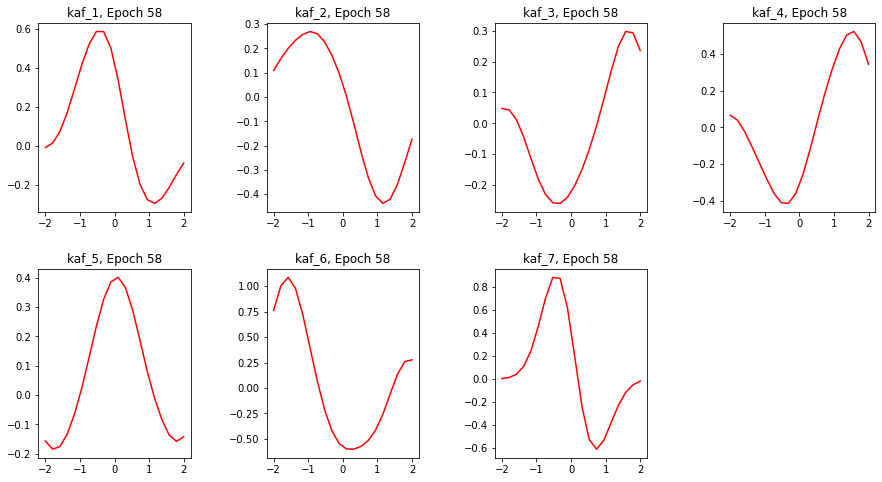

Epoch 58/100
782/782 [==============================] - 197s 252ms/step - loss: 1.3206 - accuracy: 0.4625 - val_loss: 1.3037 - val_accuracy: 0.5445


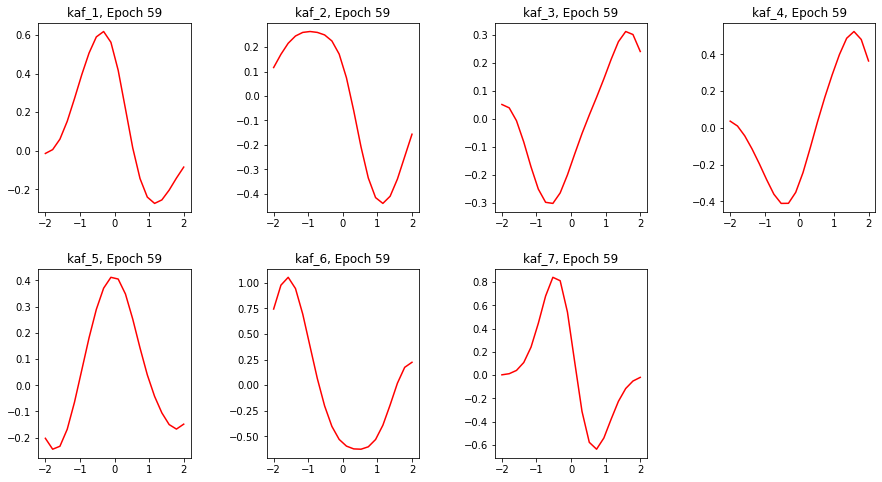

Epoch 59/100
782/782 [==============================] - 197s 252ms/step - loss: 1.3117 - accuracy: 0.4695 - val_loss: 1.1706 - val_accuracy: 0.5920


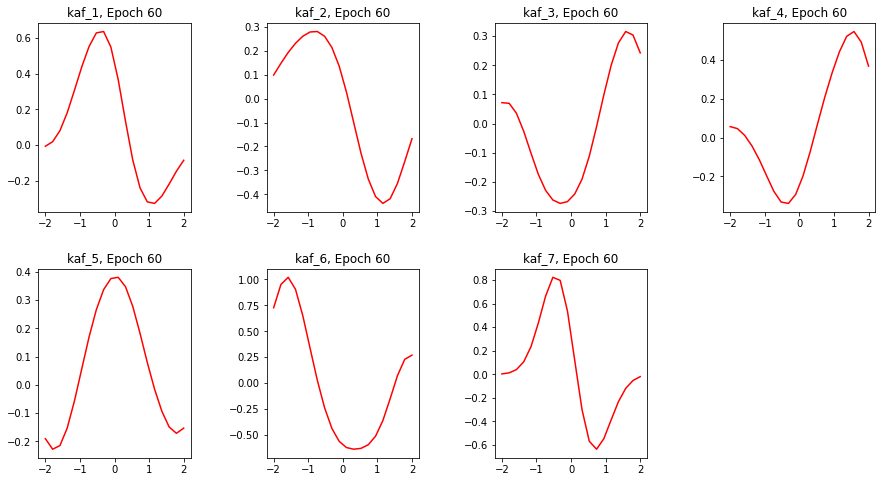

Epoch 60/100
782/782 [==============================] - 197s 252ms/step - loss: 1.2532 - accuracy: 0.4927 - val_loss: 1.0218 - val_accuracy: 0.6925


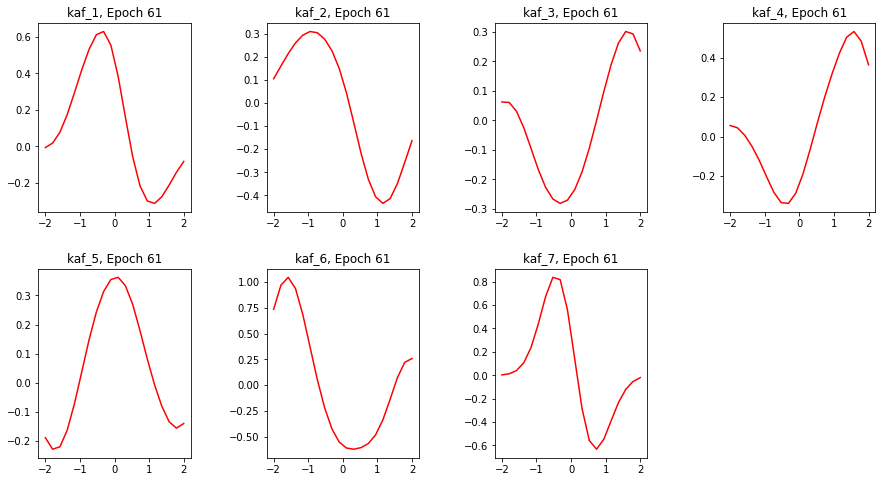

Epoch 61/100
782/782 [==============================] - 197s 252ms/step - loss: 1.2395 - accuracy: 0.4944 - val_loss: 1.0693 - val_accuracy: 0.6480


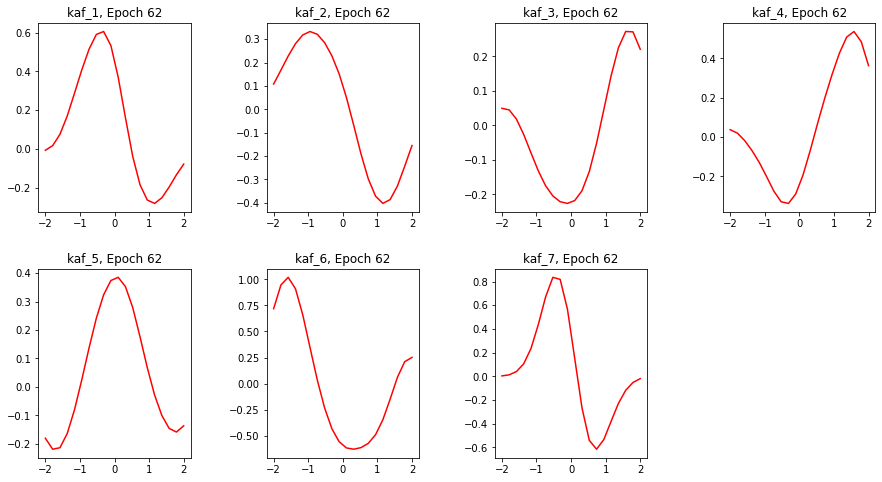

Epoch 62/100
782/782 [==============================] - 197s 252ms/step - loss: 1.3022 - accuracy: 0.4729 - val_loss: 1.5021 - val_accuracy: 0.4900


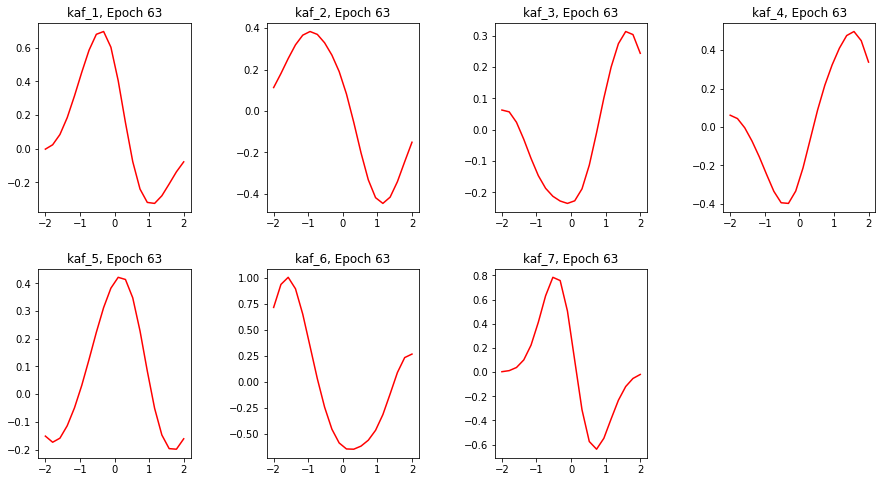

Epoch 63/100
782/782 [==============================] - 197s 252ms/step - loss: 1.2979 - accuracy: 0.4757 - val_loss: 1.0900 - val_accuracy: 0.6700


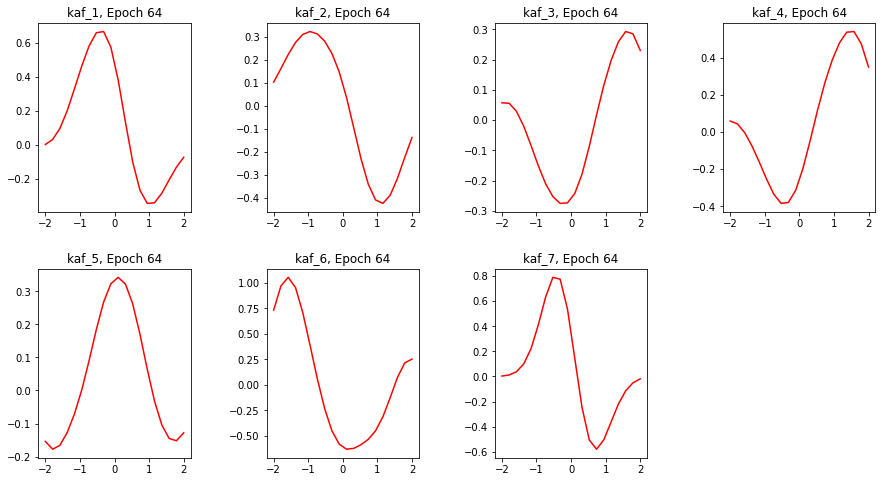

Epoch 64/100
782/782 [==============================] - 196s 251ms/step - loss: 1.2349 - accuracy: 0.4962 - val_loss: 1.0038 - val_accuracy: 0.6925


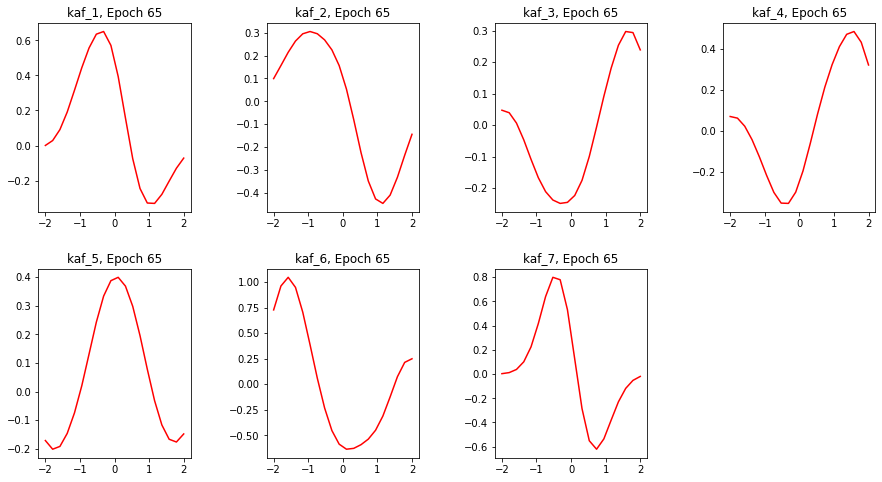

Epoch 65/100
782/782 [==============================] - 196s 251ms/step - loss: 1.2275 - accuracy: 0.4980 - val_loss: 1.1078 - val_accuracy: 0.6540


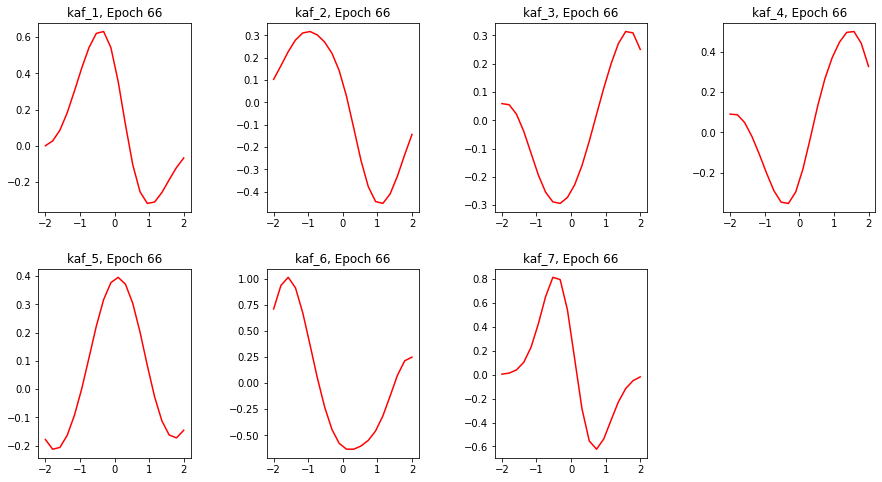

Epoch 66/100
782/782 [==============================] - 196s 251ms/step - loss: 1.2864 - accuracy: 0.4762 - val_loss: 1.3510 - val_accuracy: 0.5420


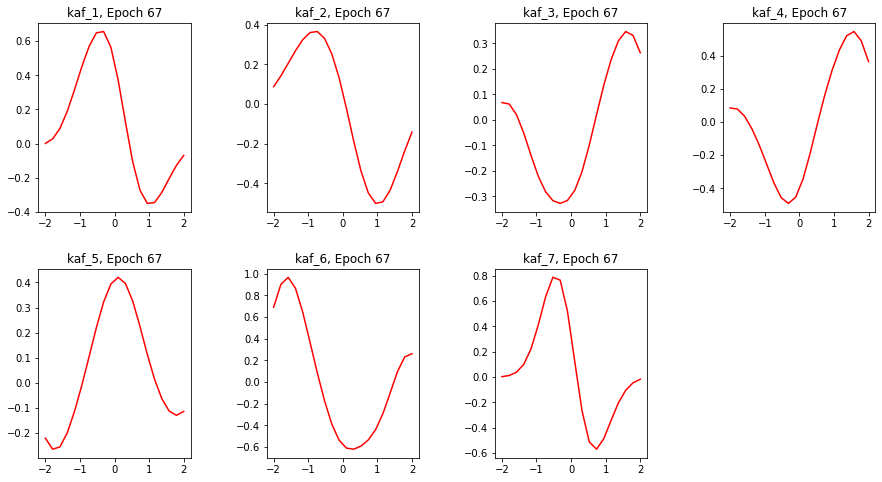

Epoch 67/100
782/782 [==============================] - 196s 251ms/step - loss: 1.2839 - accuracy: 0.4771 - val_loss: 1.1444 - val_accuracy: 0.6280


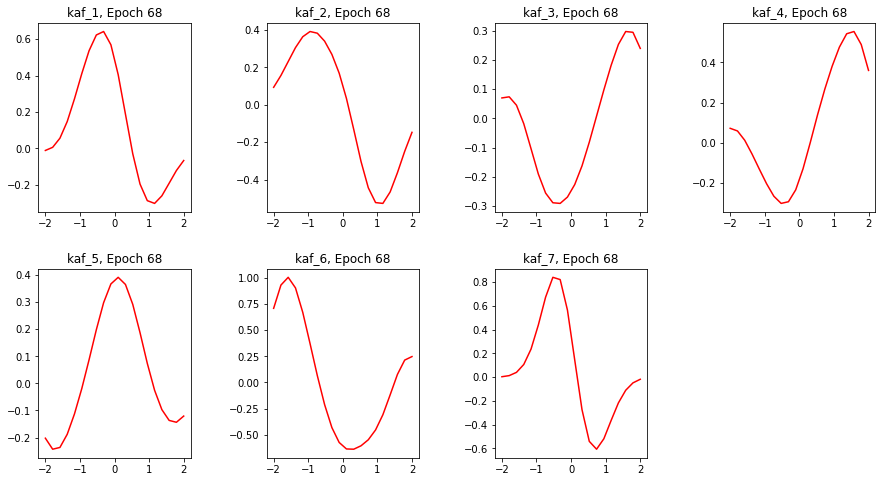

Epoch 68/100
782/782 [==============================] - 196s 251ms/step - loss: 1.2196 - accuracy: 0.5018 - val_loss: 0.9969 - val_accuracy: 0.6920


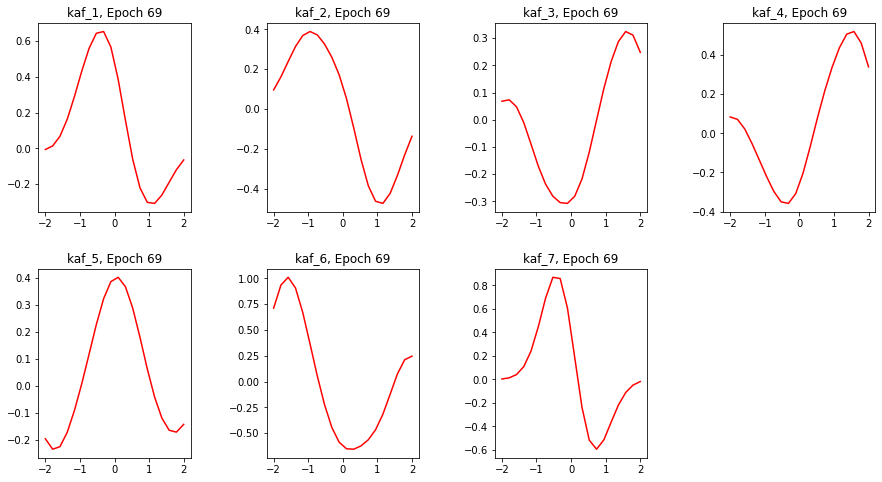

Epoch 69/100
782/782 [==============================] - 196s 251ms/step - loss: 1.2120 - accuracy: 0.5062 - val_loss: 1.0758 - val_accuracy: 0.6630


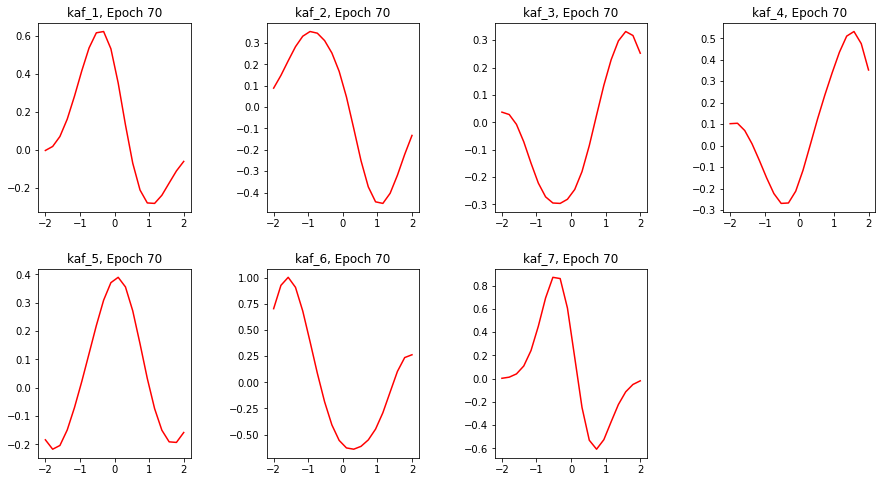

Epoch 70/100
782/782 [==============================] - 196s 251ms/step - loss: 1.2749 - accuracy: 0.4814 - val_loss: 1.3123 - val_accuracy: 0.5680
Epoch 00070: early stopping


In [12]:
history_kaf = rob_kaf_cnn.fit(x_train, y_train, epochs = 100, validation_data=(x_test[:2000], y_test[:2000]),batch_size=64, callbacks=[es, clr, activationsf.plot_kafs_epoch_wise(num_layers=7)])

In [13]:
rob_kaf_cnn.save('/content/kaf_cnn_robust_fbf') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/kaf_cnn_robust_fbf/assets


In [14]:
!zip -r kaf_cnn_robust_fbf.zip /content/kaf_cnn_robust_fbf

  adding: content/kaf_cnn_robust_fbf/ (stored 0%)
  adding: content/kaf_cnn_robust_fbf/assets/ (stored 0%)
  adding: content/kaf_cnn_robust_fbf/variables/ (stored 0%)
  adding: content/kaf_cnn_robust_fbf/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: content/kaf_cnn_robust_fbf/variables/variables.index (deflated 70%)
  adding: content/kaf_cnn_robust_fbf/variables/variables.data-00000-of-00002 (deflated 79%)
  adding: content/kaf_cnn_robust_fbf/saved_model.pb (deflated 90%)


In [15]:
from google.colab import files
files.download('/content/kaf_cnn_robust_fbf.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

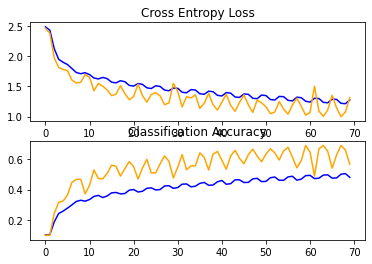

In [16]:
summarize_diagnostics(history_kaf)